# Что рассказывают трансферы о футбольной истории?

Этим летом я решил изучать науку о данных. И когда встал вопрос проекта для практики приобретённых навыков Numpy/Pandas/Matplotlib/Seaborn, я выбрал любимое хобби — футбол. Довольно быстро нашёл на Github [данные](https://github.com/ewenme/transfers) с Transfermarkt по переходам в 8 лучших профессиональных лигах Европы и Чемпионшипу с сезона 1992/1993. И вот мы здесь!

## Подготовка данных

Данные хранились в папках по каждому сезону отдельным файлом для каждой из лиг. Я решил объединить их в одну таблицу, исключив из исследований Чемпионшип. Для этого я переименовал все файлы, добавив в начало каждого сезон, к которому относятся данные, перенёс в одну папку и объединил:  

    ls | parallel -m -j 8 "cat {} >> ../top-8.csv"

Импортирую нужные библиотеки и считываю таблицу из файла.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
%matplotlib inline

In [3]:
trans = pd.read_csv('/home/eugene/Документы/transfers/data/top-8.csv')

In [4]:
trans.head()

club_name         player_name age        position  \
0  Cambuur-Leeuwarden bvo      Bert Konterman  21     Centre-Back   
1  Cambuur-Leeuwarden bvo      Guus Uhlenbeek  21      Right-Back   
2  Cambuur-Leeuwarden bvo      Mark Oosterhof  20        Defender   
3  Cambuur-Leeuwarden bvo   Ulrich Landvreugd  20      Midfielder   
4  Cambuur-Leeuwarden bvo  Michel van Oostrum  26  Centre-Forward   

  club_involved_name    fee transfer_movement fee_cleaned league_name  year  \
0          FC Zwolle  £122k                in       0.122  Eredivisie  1992   
1               Ajax      ?                in         NaN  Eredivisie  1992   
2            Wolvega      ?                in         NaN  Eredivisie  1992   
3           Ajax U21      ?                in         NaN  Eredivisie  1992   
4              Emmen      ?                in         NaN  Eredivisie  1992   

      season  
0  1992/1993  
1  1992/1993  
2  1992/1993  
3  1992/1993  
4  1992/1993

In [5]:
trans.shape

(133438, 11)

In [6]:
trans.describe()

club_name  player_name     age        position  \
count           133438       133438  133397          133437   
unique             379        29588      43              18   
top     Udinese Calcio  player_name      21  Centre-Forward   
freq              1839          216   13075           24358   

       club_involved_name     fee transfer_movement fee_cleaned league_name  \
count              133438  133284            133438      110249      133438   
unique               5139    2757                 3         928           9   
top          Without Club    Loan                in           0     Serie A   
freq                 2373   24155             67316       86087       30332   

          year     season  
count   133438     133438  
unique      29         29  
top       2014  2014/2015  
freq      7170       7170

### Предварительная очистка

Замечаю, что при соединении таблиц, заголовки всякий раз присоединялись как обычная строка. Очищу данные от них:

In [7]:
trans = trans[trans['player_name']!='player_name']

Проверю, по каким лигам есть данные за текущий сезон. Трансферное окно закрылось недавно, допускаю, что эти данные могут быть неполными.

In [8]:
trans[trans['season']=='2019/2020']['league_name'].unique()

array(['Premier League'], dtype=object)

Видим, что в таблице данные только по Английской Премьер-Лиге. Не буду брать их во внимание, чтобы все чемпионаты были на равных.

In [9]:
trans = trans[trans['season']!='2019/2020']

In [10]:
trans.shape

(132719, 11)

### Готовим колонку 'fee_cleaned' для дальнейшей работы

Наибольшая часть работы будет связана с данными в колонке 'fee_cleaned' — убежусь, что избегу базовых ошибок при работе с ними.
В выводе команды *trans.head()* вижу, что по части переходов нет информации об уплаченной сумме. Заменю NaN-значения на '0', чтобы сохранить данные о совокупной активности клубов на трансферном рынке и не столкнуться NaN при выполнении операций с числами.

In [11]:
trans['fee_cleaned'].fillna(0, inplace = True)

In [12]:
trans['fee_cleaned'].isnull().unique()

array([False])

После этого проверю, что данные в колонке — действительно числа. Если это не так, изменю тип данных.

In [13]:
trans['fee_cleaned'].describe()

count     132719
unique       915
top            0
freq       85731
Name: fee_cleaned, dtype: object

In [14]:
trans = trans.astype({'fee_cleaned': 'float64'})

In [15]:
trans.groupby('club_name', as_index=False)[['fee_cleaned']].sum().head()

club_name  fee_cleaned
0           1. FC Köln      167.190
1  1.FC Kaiserslautern       93.741
2       1.FC Nuremberg       76.800
3     1.FC Saarbrücken        0.135
4       1.FSV Mainz 05      300.941

### Объединяем команды, встречающиеся под разными названиями

За 26 сезонов названия клубов изменялись, создавались новые юридические лица после банкротства старых. Отыщу фактические дубликаты команд в лигах и приведу их к единым названиям:

In [16]:
trans[trans['league_name']=='Serie A']['club_name'].unique()

array(['Milan AC', 'AS Roma', 'Brescia Calcio', 'FC Internazionale',
       'AC Parma', 'Genoa 1893', 'SS Lazio', 'Udinese Calcio',
       'Torino Calcio', 'AC Fiorentina', 'Juventus FC', 'Foggia Calcio',
       'Atalanta BC', 'UC Sampdoria', 'Ancona Calcio', 'Cagliari Calcio',
       'Delfino Pescara 1936', 'SSC Napoli', 'Piacenza FC',
       'US Cremonese', 'AC Reggiana', 'US Lecce', 'AS Bari',
       'Calcio Padova', 'Vicenza Calcio', 'Hellas Verona', 'AC Perugia',
       'Bologna FC 1909', 'FC Empoli', 'US Salernitana 1919',
       'AC Venezia 1907', 'Reggina Calcio', 'Florentia Viola',
       'Chievo Verona', 'Como Calcio', 'Modena FC 2018', 'AC Siena',
       'AC Milan', 'Parma FC', 'US Palermo', 'FC Messina Peloro',
       'ACF Fiorentina', 'AS Livorno', 'ACD Treviso',
       'Ascoli Calcio 1898', 'Torino FC', 'Calcio Catania', 'Genoa CFC',
       'AC Cesena', 'Novara Calcio 1908', 'US Sassuolo', 'Inter Milan',
       'Carpi FC 1909', 'Frosinone Calcio', 'FC Crotone',
       'Be

In [17]:
trans[trans['club_name']=='AC Parma'].groupby('season').sum()

fee_cleaned
season                
1992/1993        0.000
1993/1994        1.440
1994/1995        7.155
1995/1996       20.137
1996/1997       27.966
1997/1998       15.300
1998/1999       35.595
1999/2000      100.880
2000/2001      124.319
2001/2002      205.289
2002/2003      123.890
2003/2004       76.694

In [18]:
trans[trans['club_name']=='Parma FC'].groupby('season').sum()

fee_cleaned
season                
2004/2005       23.742
2005/2006       34.120
2006/2007       19.788
2007/2008       18.090
2009/2010       54.733
2010/2011       37.557
2011/2012       36.239
2012/2013       40.753
2013/2014       32.295
2014/2015       30.097

In [19]:
trans[trans['club_name']=='Parma Calcio 1913'].groupby('season').sum()

fee_cleaned
season                
2018/2019        19.53

In [20]:
trans.replace(['AC Parma', 'Parma FC', 'Parma Calcio 1913', 'Milan AC', 'AC Milan', 'Genoa 1893', 'Genoa CFC', 'SPAL 2013', 'AC Fiorentina', 'ACF Fiorentina', 'Torino Calcio', 'Torino FC', 'FC Internazionale'], ['Parma', 'Parma', 'Parma', 'Milan', 'Milan', 'Genoa', 'Genoa', 'SPAL', 'Fiorentina', 'Fiorentina', 'Torino', 'Torino', 'Inter Milan'], inplace = True)

In [21]:
trans[trans['league_name']=='Premier League']['club_name'].unique()

array(['Arsenal FC', 'Ipswich Town', 'Nottingham Forest',
       'Crystal Palace', 'Manchester United', 'Coventry City',
       'Wimbledon FC', 'Sheffield Wednesday', 'Queens Park Rangers',
       'Oldham Athletic', 'Middlesbrough FC', 'Chelsea FC', 'Everton FC',
       'Liverpool FC', 'Tottenham Hotspur', 'Blackburn Rovers',
       'Southampton FC', 'Manchester City', 'Sheffield United',
       'Leeds United', 'Aston Villa', 'Norwich City', 'Newcastle United',
       'Swindon Town', 'West Ham United', 'Leicester City',
       'Bolton Wanderers', 'Derby County', 'Sunderland AFC',
       'Barnsley FC', 'Charlton Athletic', 'Watford FC', 'Bradford City',
       'Fulham FC', 'West Bromwich Albion', 'Birmingham City',
       'Portsmouth FC', 'Wolverhampton Wanderers', 'Wigan Athletic',
       'Reading FC', 'Stoke City', 'Hull City', 'Burnley FC',
       'Blackpool FC', 'Swansea City', 'Cardiff City', 'AFC Bournemouth',
       'Brighton & Hove Albion', 'Huddersfield Town'], dtype=object)

In [22]:
trans[trans['league_name']=='Ligue 1']['club_name'].unique()

array(['FC Girondins Bordeaux', 'AS Monaco', 'Olympique Marseille',
       'AJ Auxerre', 'FC Metz', 'FC Toulouse',
       'Sporting Club de Toulon et du Var', 'Paris Saint-Germain',
       'AS Saint-Étienne', 'RC Strasbourg Alsace', 'AC Le Havre',
       'FC Sochaux-Montbéliard', 'RC Lens', 'HSC Montpellier',
       'FC Nantes', 'Olympique Lyon', 'LOSC Lille', 'Nîmes Olympique',
       'SM Caen', 'Union Sportive Valenciennes-Anzin Arrondissement',
       'AS Cannes', 'FC Martigues', 'SCO Angers', 'Stade Rennais FC',
       'OGC Nice', 'SC Bastia', 'EA Guingamp', 'FC Gueugnon',
       'AS Nancy-Lorraine', 'LB Châteauroux', 'FC Lorient',
       'CS Sedan-Ardennes', 'Association Troyes Aube Champagne',
       'ES Troyes AC', 'AC Ajaccio', 'Le Mans Union Club 72',
       'FC Istres Ouest Provence', 'Valenciennes FC', 'Grenoble Foot 38',
       'US Boulogne', 'Stade Brest 29', 'Athlétic Club Arlésien',
       'FCO Dijon', 'FC Évian Thonon Gaillard', 'Stade Reims',
       'GFC Ajaccio', 'SC 

In [23]:
trans.replace(['Union Sportive Valenciennes-Anzin Arrondissement', 'Valenciennes FC', 'Association Troyes Aube Champagne', 'ES Troyes AC'], ['Valenciennes', 'Valenciennes', 'Troyes', 'Troyes'], inplace = True)

In [24]:
trans[trans['league_name']=='1 Bundesliga']['club_name'].unique()

array(['1.FC Saarbrücken', '1.FC Kaiserslautern', '1. FC Köln',
       '1.FC Nuremberg', 'Bayer 04 Leverkusen', 'Borussia Dortmund',
       'Borussia Mönchengladbach', 'Eintracht Frankfurt', 'Bayern Munich',
       'FC Schalke 04', 'Hamburger SV', 'Karlsruher SC', 'VfB Stuttgart',
       'VfL Bochum', 'SV Werder Bremen', 'Bayer 05 Uerdingen',
       'SG Wattenscheid 09', 'SG Dynamo Dresden', 'MSV Duisburg',
       'SC Freiburg', 'VfB Leipzig', 'TSV 1860 Munich',
       'FC Hansa Rostock', 'FC St. Pauli', 'KFC Uerdingen 05',
       'Fortuna Düsseldorf', 'Arminia Bielefeld', 'Hertha BSC',
       'VfL Wolfsburg', 'SpVgg Unterhaching', 'SSV Ulm 1846',
       'FC Energie Cottbus', 'Hannover 96', '1.FSV Mainz 05',
       'Alemannia Aachen', 'TSG 1899 Hoffenheim', 'FC Augsburg',
       'SpVgg Greuther Fürth', 'Eintracht Braunschweig',
       'SC Paderborn 07', 'FC Ingolstadt 04', 'SV Darmstadt 98',
       'RB Leipzig'], dtype=object)

In [25]:
trans[trans['league_name']=='Premier Liga']['club_name'].unique()

array(['Spartak Moscow', 'Rotor Volgograd', 'Dinamo Moscow',
       'Tekstilshchik Kamyshin', 'Lokomotiv Moscow',
       'Spartak Vladikavkaz', 'Torpedo Moscow', 'Uralmash Ekaterinburg',
       'CSKA Moscow', 'KamAZ Naberezhnye Chelny',
       'Lokomotiv Nizhniy Novgorod', 'Dinamo Stavropol',
       'Zhemchuzhina Sochi', 'Krylya Sovetov Samara', 'Luch Vladivostok',
       'Ocean Nakhodka', 'Rostselmash Rostov', 'Asmaral Moskau',
       'Dinamo-Gazovik Tyumen', 'Lada Togliatti',
       'Chernomorets Novorossijsk', 'Spartak-Alania Vladikavkaz',
       'Alania Vladikavkaz', 'Baltika Kaliningrad',
       'Zenit St. Petersburg', 'Shinnik Yaroslavl', 'FK Tyumen',
       'Fakel Voronezh', 'Uralan Elista', 'Saturn Ramenskoe',
       'Anzhi Makhachkala', 'Sokol Saratov', 'Torpedo-ZiL Moskau',
       'Rubin Kazan', 'FK Rostov', 'Torpedo-Metallurg Moskau',
       'FK Moskau', 'Amkar Perm', 'Kuban Krasnodar', 'Tom Tomsk',
       'Terek Grozny', 'Spartak Nalchik', 'FK Khimki',
       'Sibir Novosib

In [26]:
trans.replace(['Spartak Vladikavkaz', 'Spartak-Alania Vladikavkaz',
       'Alania Vladikavkaz', 'Uralmash Ekaterinburg', 'Rostselmash Rostov', 'FK Rostov', 'Dinamo-Gazovik Tyumen', 'FK Tyumen', 'Torpedo-Metallurg Moskau', 'Torpedo-Metallurg Moskau', 'FK Moskau'],['Vladikavkaz', 'Vladikavkaz', 'Vladikavkaz', 'Ural Yekaterinburg', 'Rostov', 'Rostov', 'Tyumen', 'Tyumen', 'FC Moskau', 'FC Moskau', 'FC Moskau'], inplace = True)

In [27]:
trans[trans['league_name']=='Primera Division']['club_name'].unique()

array(['Atlético Madrid', 'FC Barcelona', 'Real Zaragoza', 'CD Logroñés',
       'CA Osasuna', 'Rayo Vallecano', 'Sevilla FC', 'Real Madrid',
       'Athletic Bilbao', 'CD Tenerife', 'Real Sociedad',
       'RCD Espanyol Barcelona', 'Deportivo de La Coruña',
       'Celta de Vigo', 'Valencia CF', 'Albacete Balompié', 'Burgos CF',
       'Sporting Gijón', 'Real Oviedo', 'Cádiz CF', 'Real Valladolid CF',
       'Racing Santander', 'Unió Esportiva Lleida', 'Real Betis Balompié',
       'SD Compostela', 'UD Salamanca', 'CP Mérida', 'CF Extremadura',
       'Hércules CF', 'RCD Mallorca', 'Villarreal CF', 'Deportivo Alavés',
       'Málaga CF', 'CD Numancia', 'UD Las Palmas', 'Recreativo Huelva',
       'Real Murcia CF', 'Levante UD', 'Getafe CF',
       'Gimnàstic de Tarragona', 'UD Almería', 'Xerez CD', 'Granada CF',
       'Elche CF', 'SD Eibar', 'Córdoba CF', 'CD Leganés', 'Girona FC',
       'SD Huesca'], dtype=object)

In [28]:
trans[trans['league_name']=='Eredivisie']['club_name'].unique()

array(['Cambuur-Leeuwarden bvo', 'Roda JC Kerkrade', 'FC Utrecht',
       'FC Groningen', 'Feyenoord Rotterdam', 'RKC Waalwijk',
       'FC Twente Enschede', 'PSV Eindhoven', 'MVV Maastricht',
       'Fortuna Sittard', 'Willem II Tilburg', 'FC Den Bosch',
       'Sparta Rotterdam', 'Vitesse Arnhem', 'Ajax Amsterdam',
       'FC Volendam', 'Go Ahead Eagles Deventer', "Dordrecht'90",
       'NAC Breda', 'VVV-Venlo', 'SC Heerenveen', 'NEC Nijmegen',
       'De Graafschap Doetinchem', 'AZ Alkmaar', 'RBC Roosendaal',
       'FC Zwolle', 'SBV Excelsior Rotterdam', 'ADO Den Haag',
       'Heracles Almelo', 'PEC Zwolle', 'SC Cambuur-Leeuwarden',
       'FC Dordrecht', 'FC Emmen'], dtype=object)

In [29]:
trans.replace(['Cambuur-Leeuwarden bvo', 'SC Cambuur-Leeuwarden', 'FC Zwolle', 'PEC Zwolle'], ['Cambuur', 'Cambuur', 'Zwolle', 'Zwolle'], inplace=True)

In [30]:
trans[trans['league_name']=='Liga Nos']['club_name'].unique()

array(['FC Porto', 'SL Benfica', 'Sporting CP', 'Boavista Porto FC',
       'CS Marítimo', 'SC Farense', 'Belenenses SAD', 'SC Beira-Mar',
       'Gil Vicente FC', 'FC Paços de Ferreira', 'Vitória Guimarães SC',
       'SC Braga', 'GD Estoril', 'FC Famalicão', 'SC Salgueiros',
       'FC Tirsense', 'SC Espinho', 'GD Chaves', 'Vitória Setúbal FC',
       'CF Estrela Amadora', 'CF União Madeira', 'União de Leiria',
       'Leça FC', 'FC Felgueiras 1932', 'SC Campomaiorense', 'Rio Ave FC',
       'Académica Coimbra', 'Varzim Sport Club', 'FC Alverca',
       'CD Santa Clara', 'Desportivo Aves', 'CD Nacional',
       'Moreirense FC', 'FC Penafiel', 'Naval 1º de Maio', 'Leixões SC',
       'CD Trofense', 'SC Olhanense', 'Portimonense SC', 'CD Feirense',
       'FC Arouca', 'CD Tondela'], dtype=object)

## Приступаю к анализу

In [31]:
trans['league_name'].describe()

count      132719
unique          8
top       Serie A
freq        30332
Name: league_name, dtype: object

In [32]:
trans['club_name'].describe()

count     132719
unique       360
top        Parma
freq        2144
Name: club_name, dtype: object

In [33]:
trans['position'].describe()

count             132718
unique                17
top       Centre-Forward
freq               24262
Name: position, dtype: object

In [34]:
trans['age'].describe()

count     132678
unique        42
top           21
freq       13024
Name: age, dtype: object

In [35]:
trans['fee_cleaned'].describe()

count    132719.000000
mean          0.683907
std           3.333662
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         199.800000
Name: fee_cleaned, dtype: float64

### Первые выводы:
* __Серия А__ —  самая активная лига. Немалую роль в этом играет специфичная для Италии практика [cовладения](https://www.mirror.co.uk/sport/football/news/forget-premier-league-feeder-clubs-2287846);
* __Парма__ — самый __активный__ клуб на трансферном рынке. Этому способствовала [золотая эра на стыке веков и распродажи на фоне двух банкротств](https://www.11v11.com/parma-story-of-greatness-and-decline/);
* Самый обильный на переходы сезон — __2014/2015__;
* Чаще всего объектами переходов становятся __центрфорварды__;
* Наибольшая часть переходов связана с __21-летними__ футболистами.

### Изучаю топы расходов и доходов клубов от трансферов
Посмотрю, сколько тратили и зарабатывали команды топ-8 европейских лиг с сезона 1992/1993 по сезон 2018/2019, а также на баланс трат.  
Создаю таблицы *clubs_tr_in* и *clubs_tr_out* — в них будут данные по суммам покупок и продаж клубов в каждом сезоне. В таблицу *clubs_total* занесу эти данные и рассчитаю баланс трат.

*Допущение: Здесь и далее данные синхронизированы под систему "осень-весна", которая практикуется в ключевых европейских чемпионатах. Чемпионат России проводился по системе "весна-осень" в 1992—2010 годах: официальные данные по сезонам в эти годы отличаются от указанных у меня*

In [36]:
transin = trans[trans['transfer_movement']=='in']
transout = trans[trans['transfer_movement']=='out']
clubs_tr_in = transin.groupby(['club_name', 'league_name', 'season'], as_index=False)[['fee_cleaned']].sum()
clubs_tr_out = transout.groupby(['club_name', 'league_name', 'season'], as_index=False)[['fee_cleaned']].sum()
clubs_tr_in.rename({'fee_cleaned':'fee_in'}, axis = 'columns', inplace = True)
clubs_tr_out.rename({'fee_cleaned':'fee_out'}, axis = 'columns', inplace = True)
clubs_total = clubs_tr_in.merge(clubs_tr_out)
clubs_total['fee_balance']=clubs_total['fee_out']-clubs_total['fee_in']
clubs_total.head()

club_name   league_name     season  fee_in  fee_out  fee_balance
0  1. FC Köln  1 Bundesliga  1992/1993   0.406    0.000       -0.406
1  1. FC Köln  1 Bundesliga  1993/1994   1.126    1.620        0.494
2  1. FC Köln  1 Bundesliga  1994/1995   1.288    0.788       -0.500
3  1. FC Köln  1 Bundesliga  1995/1996   3.483    3.150       -0.333
4  1. FC Köln  1 Bundesliga  1996/1997   1.980    2.340        0.360

Создам цветовую гамму для визуализации данных по лигам на основе их официальных цветов:

In [37]:
colors = dict(zip(
    ['Premier League', 'Ligue 1', '1 Bundesliga', 'Serie A', 'Premier Liga','Primera Division', 'Eredivisie', 'Liga Nos'],
    ["#3d195b", "#e1de07", "#d20614", "#048dd6", "#021035", "#00953e", "#002f63", "#eb84cd"]
))
group_lk = trans.set_index('club_name')['league_name'].to_dict()

Идею визуализации я позаимствовал [здесь](https://towardsdatascience.com/bar-chart-race-in-python-with-matplotlib-8e687a5c8a41). Немного адаптировал и универсализировал функцию под свои нужды.  
По итогам, выделю наиболее интересные для дальнейшего изучения клубы и тенденции, о которых постараюсь рассказать подробнее позже.

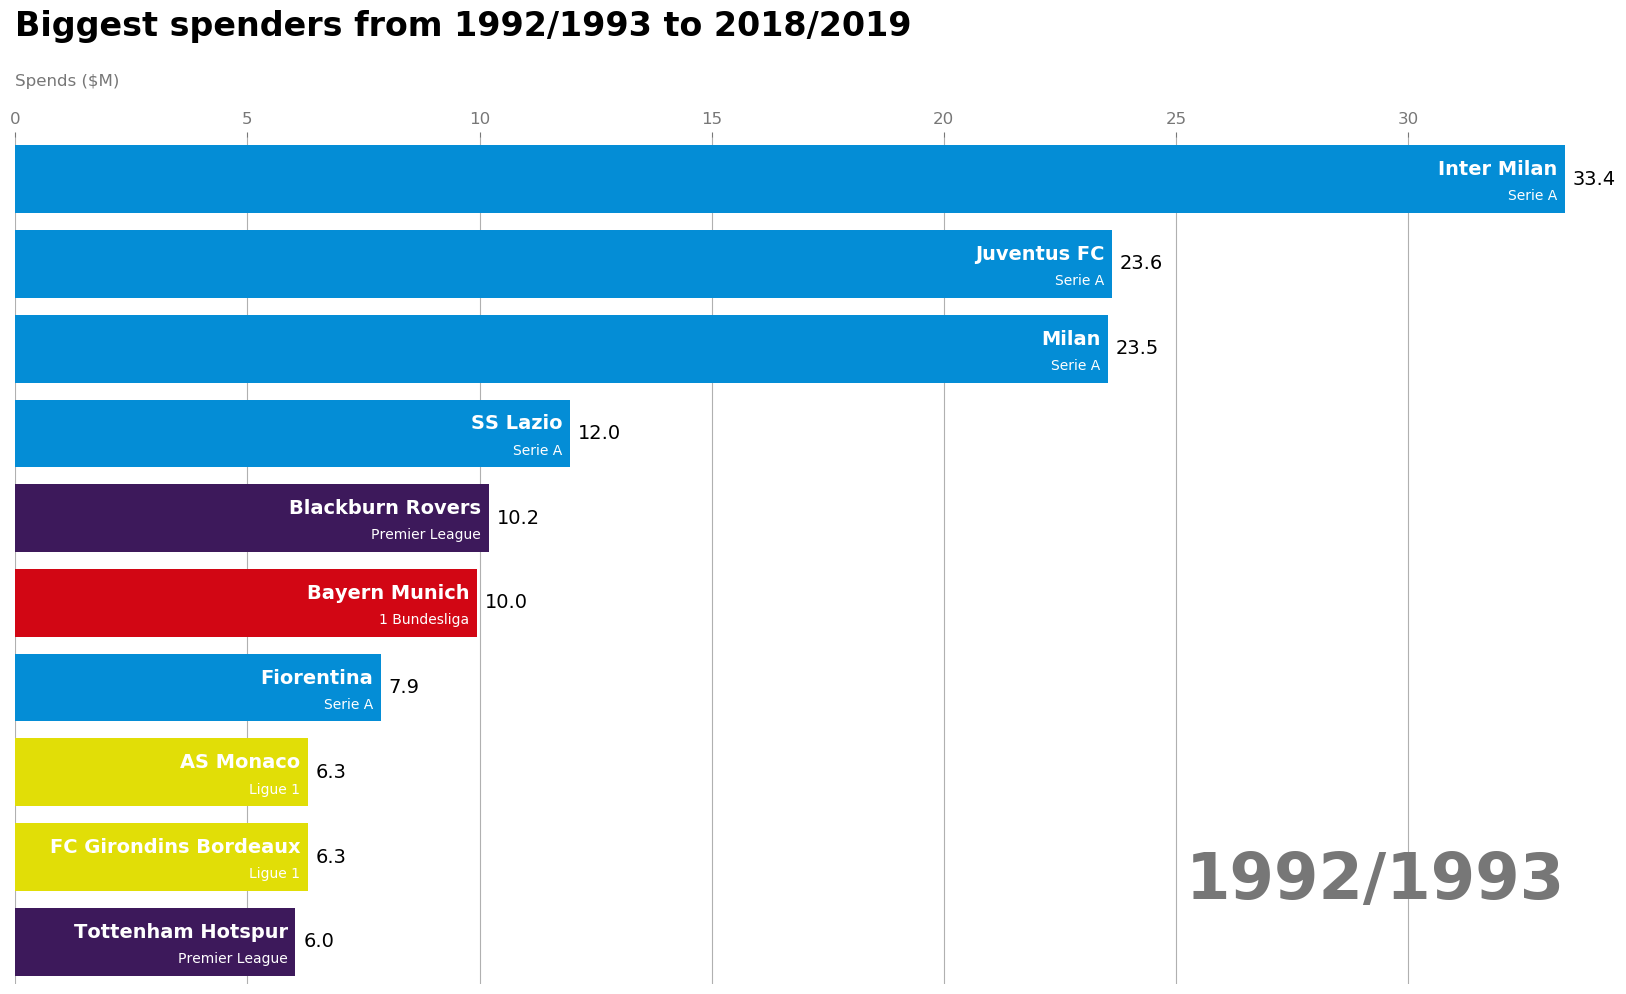

In [38]:
fig, ax = plt.subplots(figsize=(20,11))

def Bar_chart(season, data, fee):
    dff = data[data['season'].eq(season)].sort_values(by=fee, ascending=True).tail(10)
    ax.clear()
    if fee == 'fee_in':
        ax.text(0, 1.06, 'Spends ($M)', transform=ax.transAxes, size=12, color='#777777')
        ax.text(0, 1.15, 'Biggest spenders from 1992/1993 to 2018/2019',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    elif fee == 'fee_out':
        ax.text(0, 1.06, 'Earnings ($M)', transform=ax.transAxes, size=12, color='#777777')
        ax.text(0, 1.15, 'Biggest earners from 1992/1993 to 2018/2019',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    elif fee == 'fee_balance':
        ax.text(0, 1.06, 'Earnings ($M)', transform=ax.transAxes, size=12, color='#777777')
        ax.text(0, 1.15, 'Best spends/earings balance from 1992/1993 to 2018/2019',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')   
    ax.barh(dff['club_name'], dff[fee], color=[colors[group_lk[x]] for x in dff['club_name']])
    dx = dff[fee].max() / 200
    for i, (fee, club_name) in enumerate(zip(dff[fee], dff['club_name'])):
        ax.text(fee-dx, i,     club_name,           size=14, weight=600, color='#ffffff', ha='right', va='bottom')
        ax.text(fee-dx, i-.25, group_lk[club_name], size=10, color='#ffffff', ha='right', va='baseline')
        ax.text(fee+dx, i,     f'{fee:,.1f}',  size=14, ha='left',  va='center')
    ax.text(1, 0.1, season, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    plt.box(False)
    
Bar_chart('1992/1993', clubs_total, 'fee_in')

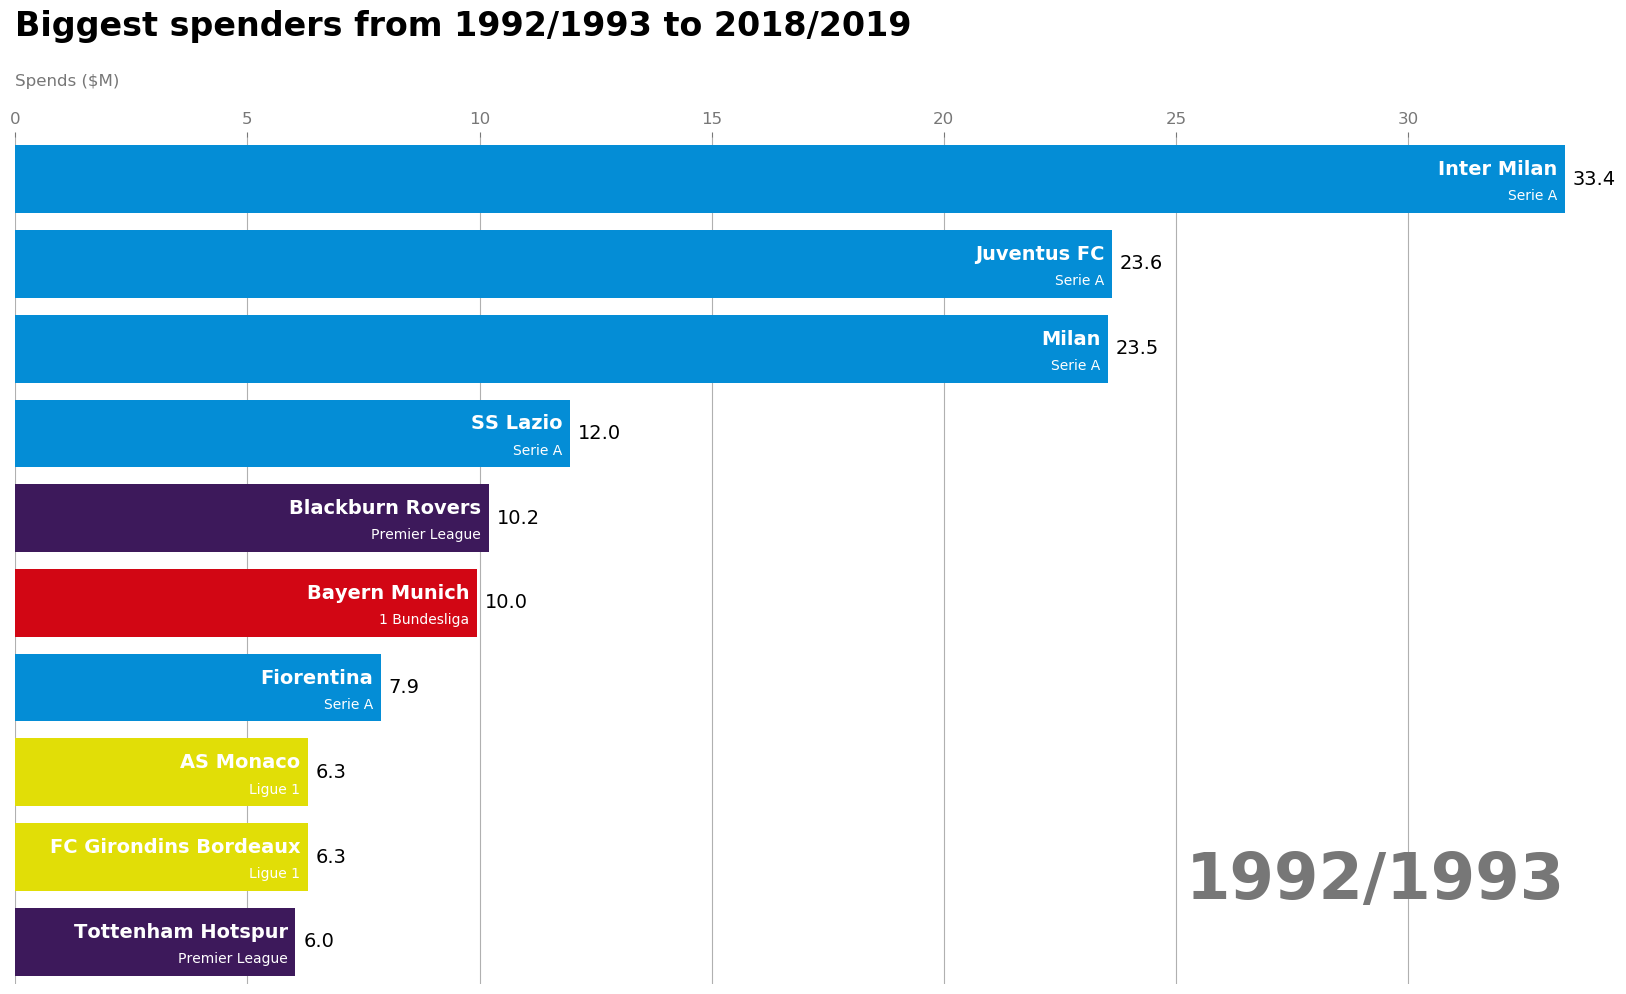

In [39]:
fig, ax = plt.subplots(figsize=(20, 11))
animator = animation.FuncAnimation(fig, Bar_chart, frames=(sorted(list(set(clubs_total['season'])))), fargs=(clubs_total, 'fee_in'), interval=1500)
HTML(animator.to_html5_video())
####### Check it in the "media" directory on Github.

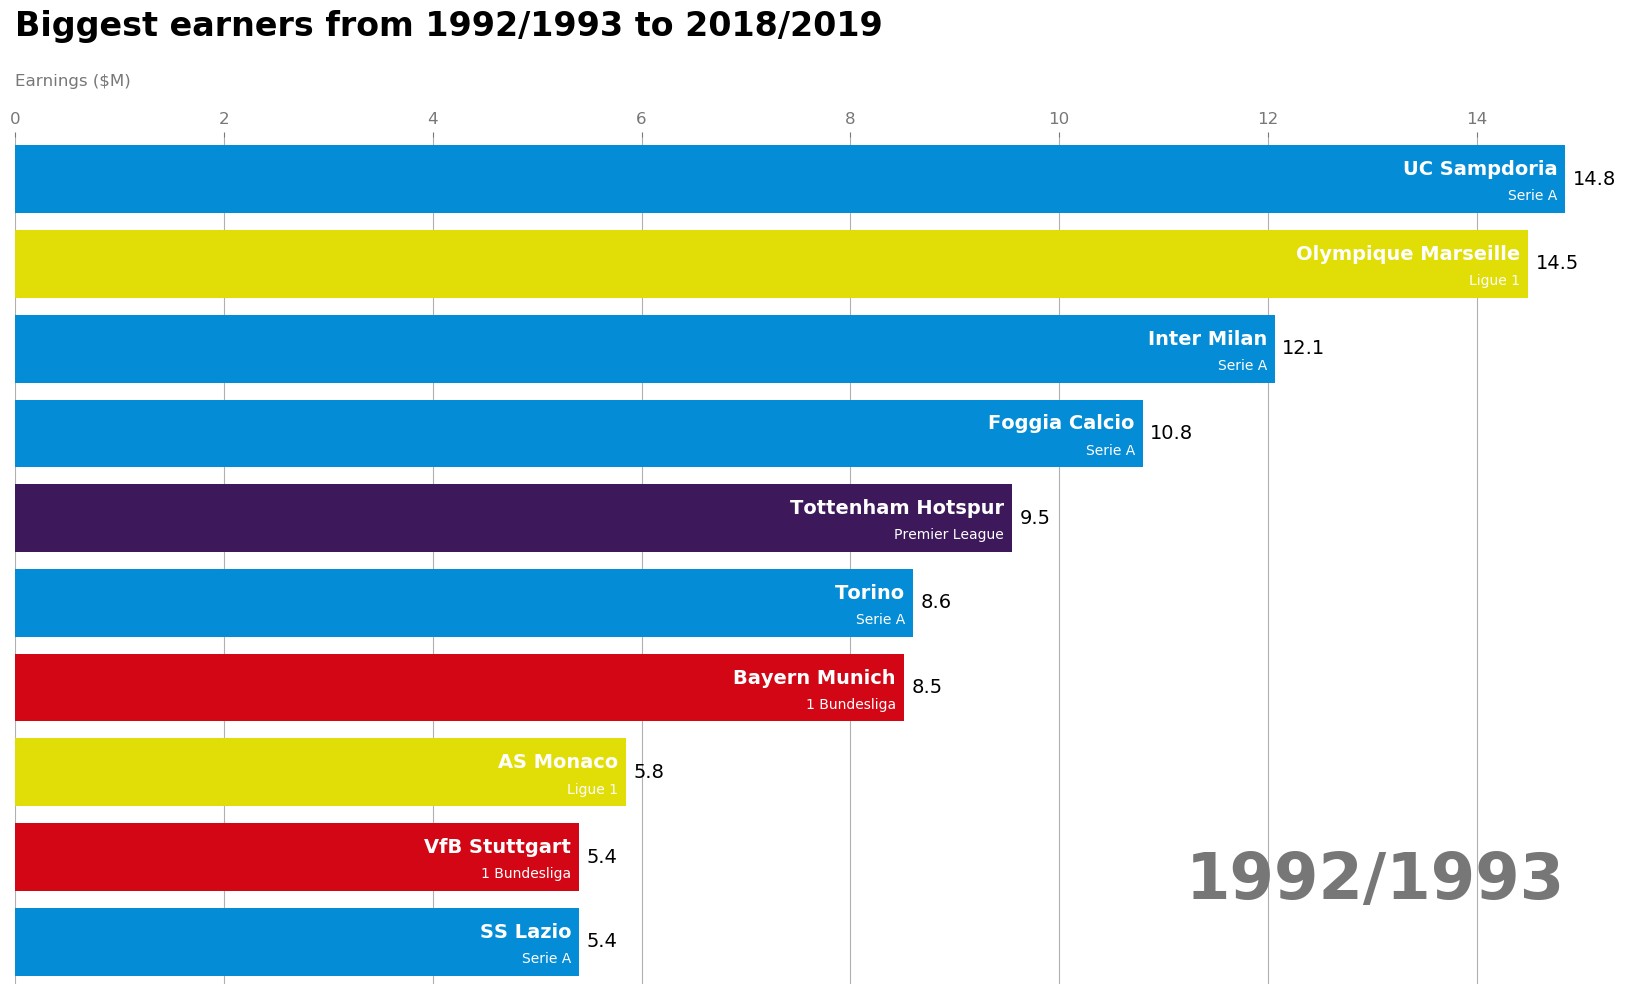

In [40]:
fig, ax = plt.subplots(figsize=(20, 11))
animator = animation.FuncAnimation(fig, Bar_chart, frames=(sorted(list(set(clubs_total['season'])))), fargs=(clubs_total, 'fee_out'), interval=1500)
HTML(animator.to_html5_video())
####### Check it in the "media" directory on Github.

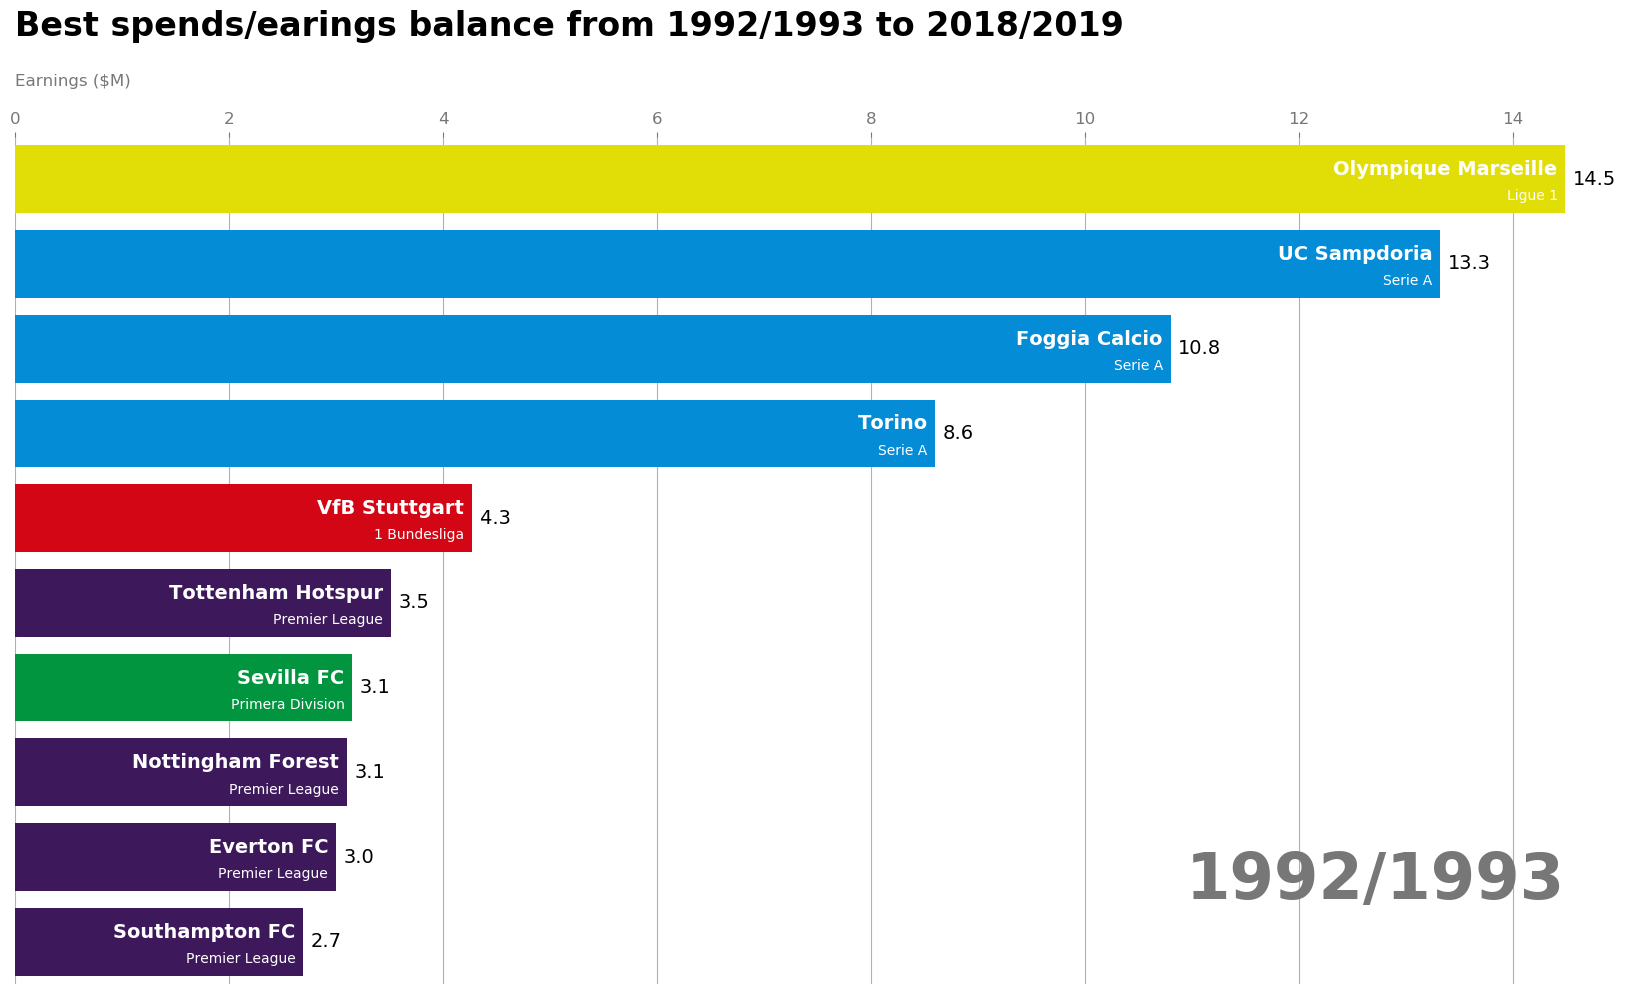

In [41]:
fig, ax = plt.subplots(figsize=(20, 11))
animator = animation.FuncAnimation(fig, Bar_chart, frames=(sorted(list(set(clubs_total['season'])))), fargs=(clubs_total, 'fee_balance'), interval=1500)
HTML(animator.to_html5_video())
####### Check it in the "media" directory on Github.

Теперь посмотрю, какие клубы тратили и зарабатывали больше всех за весь период наблюдений:

In [42]:
clubs_tot_sum=clubs_total.groupby(['club_name', 'league_name'], as_index=False)[['fee_in', 'fee_out', 'fee_balance']].sum()
clubs_tot_sum.head()

club_name   league_name   fee_in  fee_out  fee_balance
0           1. FC Köln  1 Bundesliga  114.969   52.221      -62.748
1  1.FC Kaiserslautern  1 Bundesliga   57.931   35.810      -22.121
2       1.FC Nuremberg  1 Bundesliga   36.902   39.898        2.996
3     1.FC Saarbrücken  1 Bundesliga    0.135    0.000       -0.135
4       1.FSV Mainz 05  1 Bundesliga  131.105  169.836       38.731

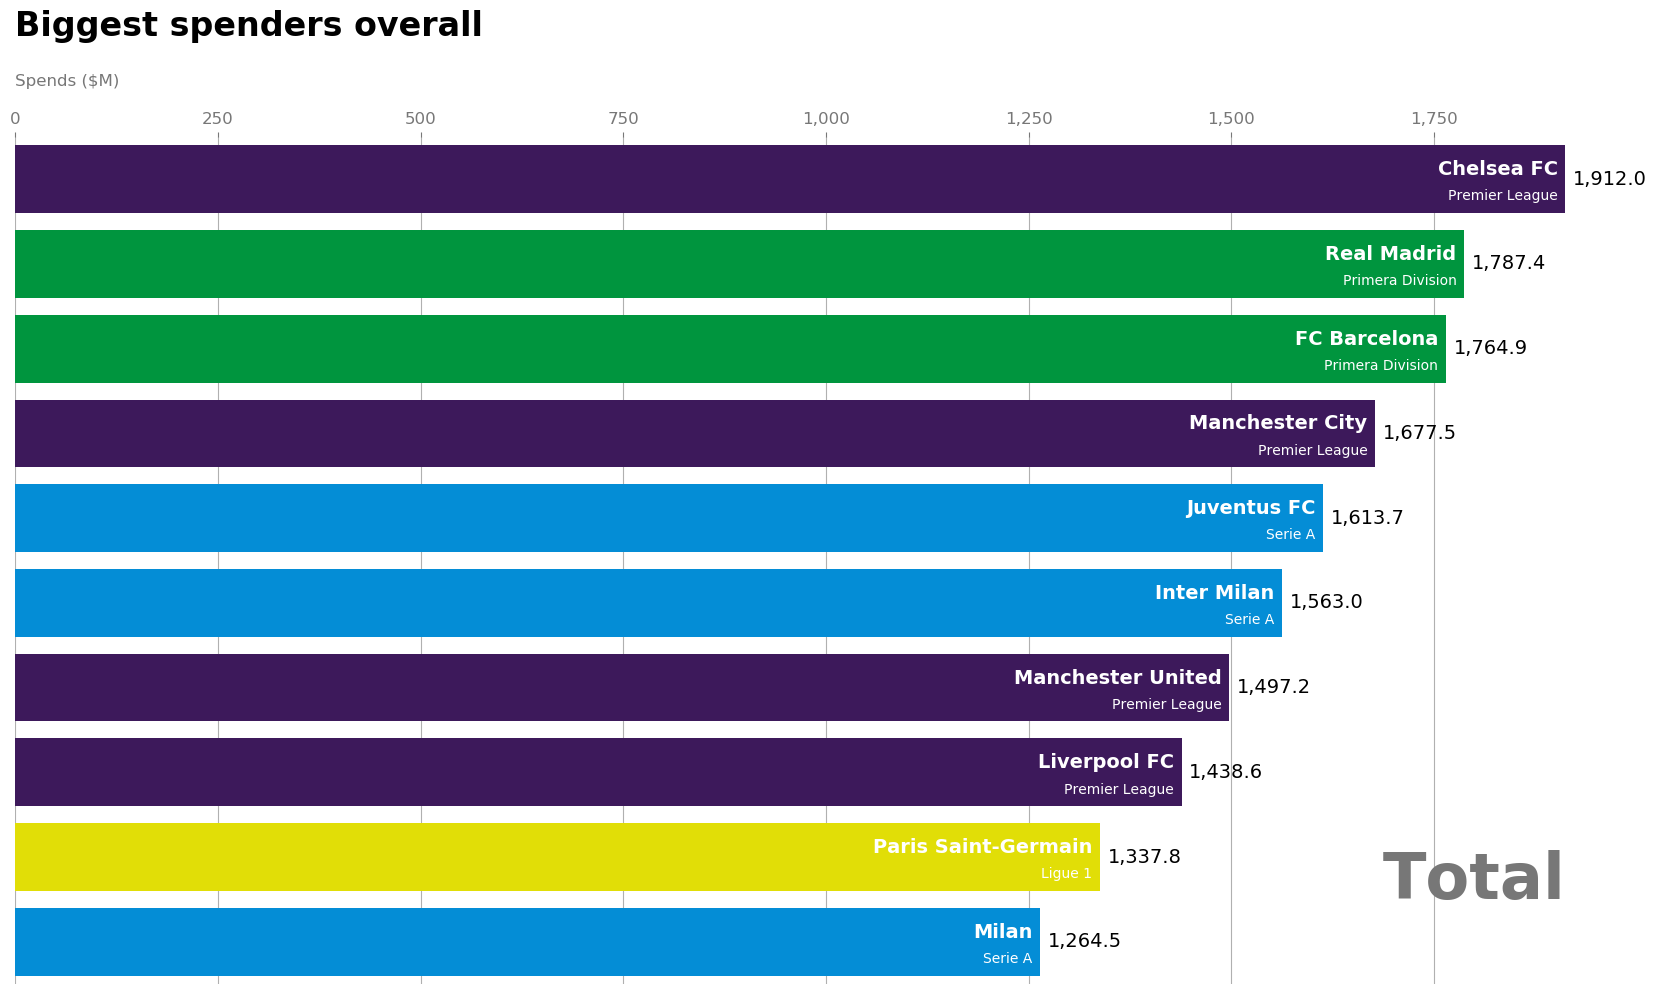

In [43]:
fig, ax = plt.subplots(figsize=(20,11))

def Total_Bar_Chart(fee, data):
    dff = data.sort_values(by=fee, ascending=True).tail(10)
    ax.clear()
    if fee == 'fee_in':
        ax.text(0, 1.06, 'Spends ($M)', transform=ax.transAxes, size=12, color='#777777')
        ax.text(0, 1.15, 'Biggest spenders overall',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    elif fee == 'fee_out':
        ax.text(0, 1.06, 'Earnings ($M)', transform=ax.transAxes, size=12, color='#777777')
        ax.text(0, 1.15, 'Biggest earners overall',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    elif fee == 'fee_balance':
        ax.text(0, 1.06, 'Earnings ($M)', transform=ax.transAxes, size=12, color='#777777')
        ax.text(0, 1.15, 'Best spends/earings balance overall',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')   
    ax.barh(dff['club_name'], dff[fee], color=[colors[group_lk[x]] for x in dff['club_name']])
    dx = dff[fee].max() / 200
    for i, (fee, club_name) in enumerate(zip(dff[fee], dff['club_name'])):
        ax.text(fee-dx, i,     club_name,           size=14, weight=600, color='#ffffff', ha='right', va='bottom')
        ax.text(fee-dx, i-.25, group_lk[club_name], size=10, color='#ffffff', ha='right', va='baseline')
        ax.text(fee+dx, i,     f'{fee:,.1f}',  size=14, ha='left',  va='center')
    ax.text(1, 0.1, 'Total', transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    plt.box(False)
    
Total_Bar_Chart('fee_in', clubs_tot_sum)

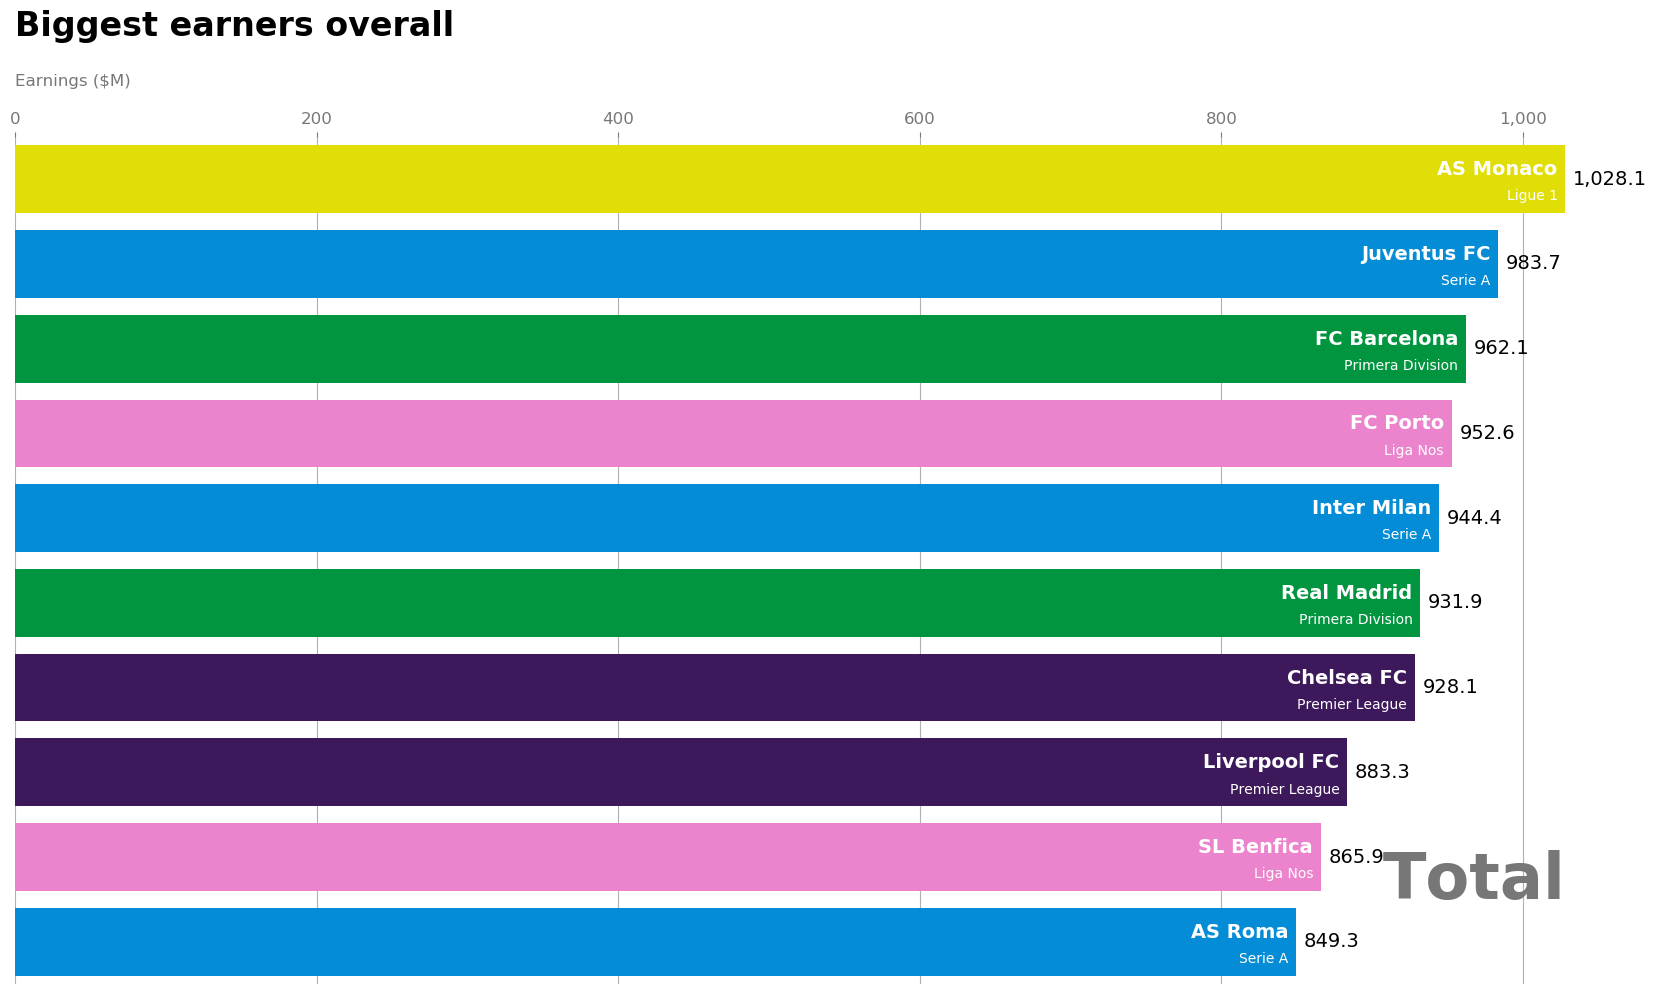

In [44]:
fig, ax = plt.subplots(figsize=(20,11))
Total_Bar_Chart('fee_out', clubs_tot_sum)

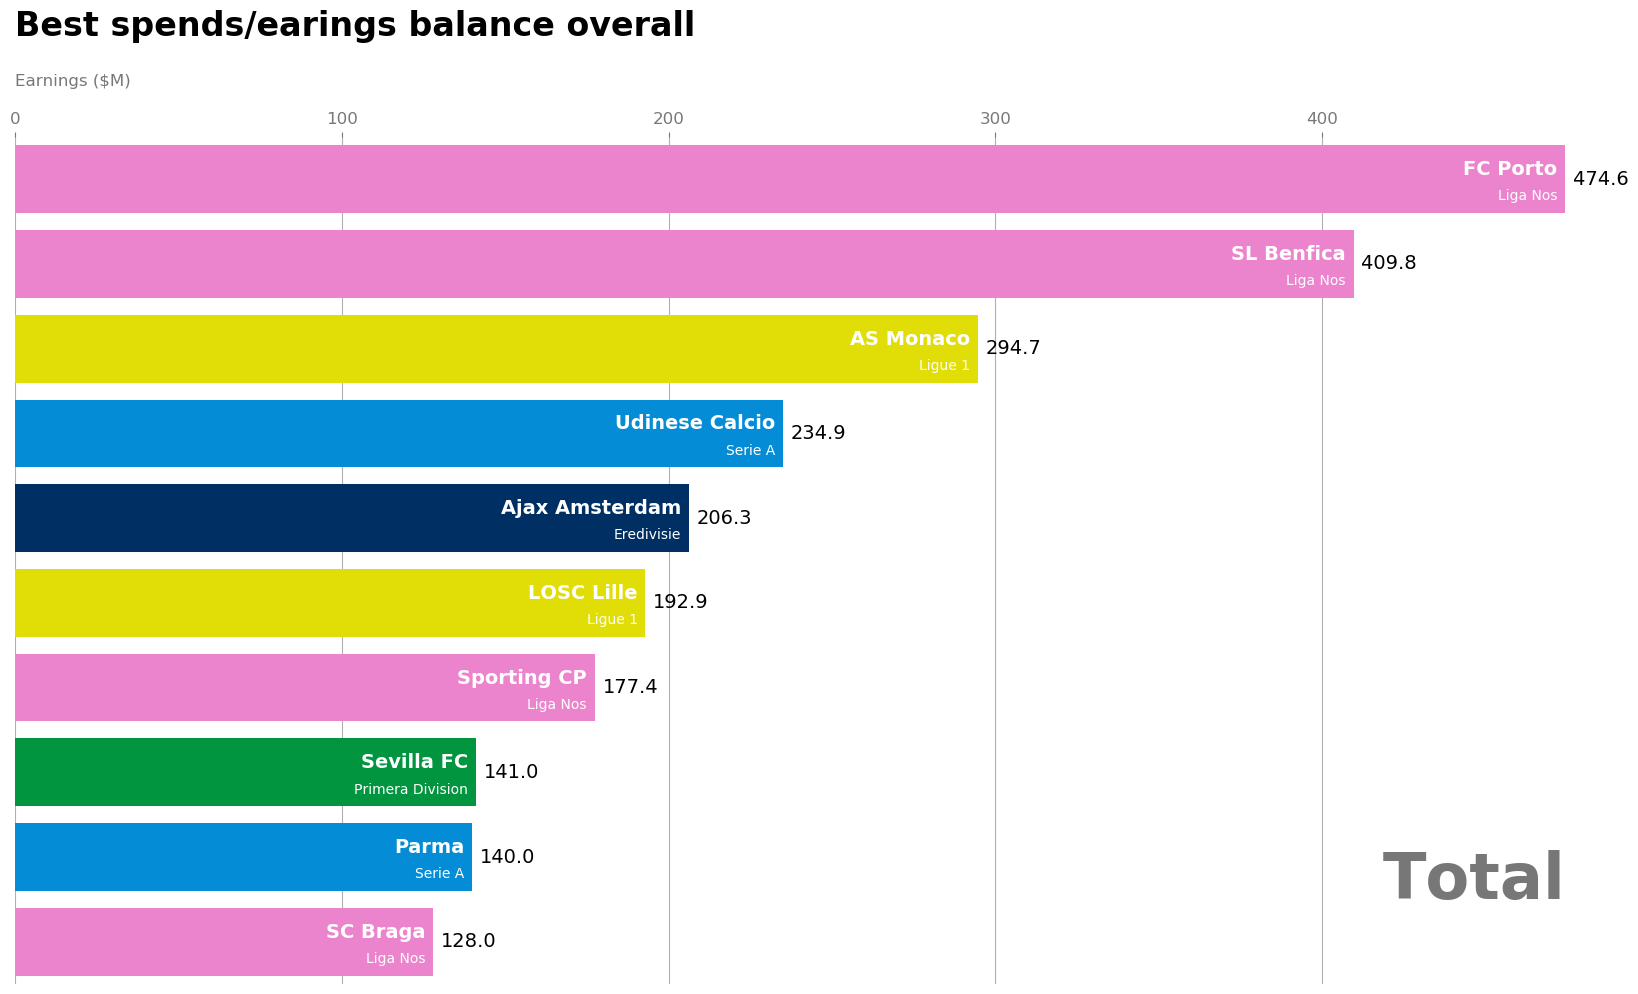

In [45]:
fig, ax = plt.subplots(figsize=(20,11))
Total_Bar_Chart('fee_balance', clubs_tot_sum)

### Worst balance

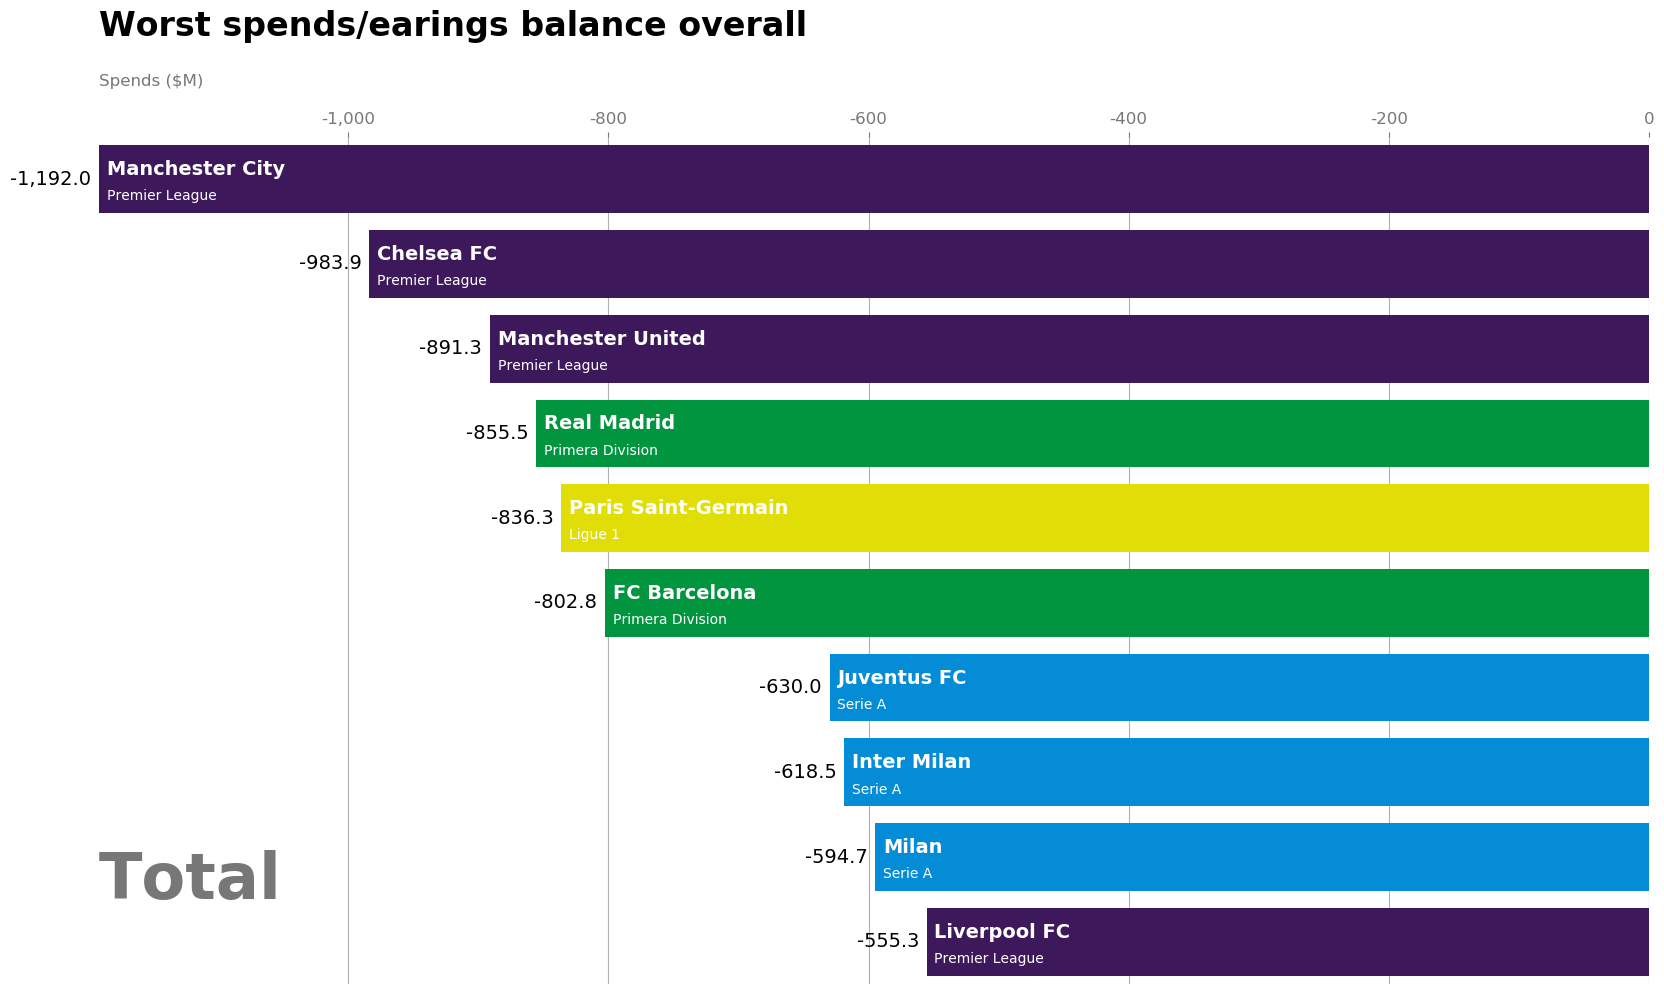

In [46]:
fig, ax = plt.subplots(figsize=(20,11))

def Total_Bar_Chart_w(fee, data):
    dff = data.sort_values(by=fee, ascending=False).tail(10)
    ax.clear()
    ax.text(0, 1.06, 'Spends ($M)', transform=ax.transAxes, size=12, color='#777777')
    ax.text(0, 1.15, 'Worst spends/earings balance overall',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')   
    ax.barh(dff['club_name'], dff[fee], color=[colors[group_lk[x]] for x in dff['club_name']])
    dx = dff[fee].min() / 200
    for i, (fee, club_name) in enumerate(zip(dff[fee], dff['club_name'])):
        ax.text(fee-dx, i,     club_name,           size=14, weight=600, color='#ffffff', ha='left', va='bottom')
        ax.text(fee-dx, i-.25, group_lk[club_name], size=10, color='#ffffff', ha='left', va='baseline')
        ax.text(fee+dx, i,     f'{fee:,.1f}',  size=14, ha='right',  va='center')
    ax.text(0, 0.1, 'Total', transform=ax.transAxes, color='#777777', size=46, ha='left', weight=800)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    plt.box(False)
    
Total_Bar_Chart_w('fee_balance', clubs_tot_sum)

Изучив визуализацию, выделил самые интересные команды/явления и отсортировал их по лигам.

 ##### АПЛ
* Блэкберн 92/93, 98/99
* Ньюкасл 95/96, 97/98
* Лидс 96/97, 99/00, 00/01 — крупные кредиты с надеждой на Лигу Чемпионов, которые привели к дальнейшим распродажам и вылету. В 2019 году Лидс проходит этап Бьелсизма и надеется вернуться в Премьер Лигу впервые с тех пор.
* Мидлсбро 96/97, 02/03
* Челси 03/04, 04/05
* Вест Хэм 06/07, 08/09
* Астон Вилла 08/09, 09/10
* Шэффилд Уэнсдэй 93/94, 94/95
* Ковентри 94/95
* Ноттингем 95/96
* Куинс парк рейнджерс 95/96
* Портсмут 08/09
* Сандерленд 10/11
* Суонси 14/15  

##### Серия А
* Парма 95/96, 98/99, 99/00, 00/01, 01/02, 02/03
* Лацио 98/99, 99/00, 00/01, 01/02
* Рома 99/00, 00/01
* Фиорентина 00/01
* Дженоа 09/10, 10/11, 11/12, 12/13
* Фоджа 92/93
* Бари 98/99
* Перуджа 99/00, 02/03
* Флоренция 01/02
* Эмполи 02/03
* Лечче 04/05
* Палермо 06/07
* Удинезе — отличный баланс трансферов  

##### Лига 1
* ПСЖ 00/01, 03/04
* Лион 03/04, 05/06
* Ланс 99/00
* Ренн 06/07
* Лилль — отличный баланс трансферов без появления в топах  

##### Ла Лига
* Депортиво 96/97, 00/01, 02/03
* Мальорка 04/05
* Вильяреал 07/08
* Сарагоса 00/01  

##### Бундеслига
* Вольфсбург 10/11
* Хоффенхайм 10/11
* Динамо Дрезден 93/94  

##### РПЛ
* Динамо 05/06, 06/07, 08/09
* Анжи 12/13, 13/14
* Зенит 06/07, 12/13  

##### Эредивизие
* ПСВ 94/95
* Аякс 97/98
* Фейенорд 06/07
* Витесс 99/00
* Херенвен 05/06  

##### Лига Нос  
Интересен подход португальских клубов к трансферному рынку в целом: в топе команд с лучшим трансферным балансом за весь период наблюдения четыре команды из Португалии.

### Взрывы рынка

Посмотрю, кто чаще других "взрывал" трансферный рынок, какой "взрыв" оказался самым мощным и кто последним заслужил прозвище "денежного мешка"?

#### Покупки

In [47]:
checkin=clubs_tr_in.pivot_table(index='club_name', columns = 'season').fillna(0)
checkedin10 = checkin[((checkin.sub(checkin.mean()) > checkin.std()*10))].dropna(how='all')
checkedin10 = checkedin10.unstack().dropna()
checkedin10

        season     club_name      
fee_in  1992/1993  Inter Milan         33.390
        1996/1997  Real Madrid         54.540
        1998/1999  SS Lazio            92.645
        1999/2000  Inter Milan        127.970
        2002/2003  Inter Milan         98.640
        2003/2004  Chelsea FC         152.280
        2004/2005  Chelsea FC         149.760
        2009/2010  Real Madrid        232.650
        2010/2011  Manchester City    165.250
dtype: float64

Замечаю, что чаще остальных в этом топе появлялся Миланский Интернационале. Он же первым пробил отметку в 100 миллионов фунтов стерлингов, потраченных в течение одного сезона.

In [48]:
checkedin13 = checkin[((checkin.sub(checkin.mean()) > checkin.std()*13))].dropna(how='all')
checkedin13 = checkedin13.unstack().dropna()
checkedin13

        season     club_name 
fee_in  2003/2004  Chelsea FC    152.28
dtype: float64

Самый мощный "взрыв" произошёл в сезоне 2002/2003 — первом для Романа Абрамовича в Челси.

In [49]:
checkedin8 = checkin[((checkin.sub(checkin.mean()) > checkin.std()*8))].dropna(how='all')
checkedin8 = checkedin8.unstack().dropna()
checkedin8

        season     club_name          
fee_in  1992/1993  Inter Milan             33.390
                   Juventus FC             23.630
                   Milan                   23.540
        1993/1994  SS Lazio                21.780
        1996/1997  Real Madrid             54.540
        1997/1998  FC Barcelona            53.280
                   Inter Milan             65.430
        1998/1999  SS Lazio                92.645
        1999/2000  Inter Milan            127.970
        2001/2002  Juventus FC            161.180
        2002/2003  Inter Milan             98.640
        2003/2004  Chelsea FC             152.280
        2004/2005  Chelsea FC             149.760
        2005/2006  Chelsea FC              82.350
        2006/2007  Real Madrid             92.700
        2008/2009  Manchester City        141.620
        2009/2010  Real Madrid            232.650
        2010/2011  Manchester City        165.250
        2012/2013  Paris Saint-Germain    135.900
        201

А последним клубом, взорвавшим рынок трансферов, стала Барселона 17/18 годов, когда к клубу в течение одного трансферного окна присоединились сразу два игрока стоимостью более 100 миллионов фунтов.

In [50]:
trans[(trans['club_name']=='FC Barcelona') & (trans['season']=='2017/2018') & (trans['transfer_movement']=='in')]

club_name        player_name age            position  \
125634  FC Barcelona  Philippe Coutinho  25         Left Winger   
125635  FC Barcelona    Ousmane Dembélé  20         Left Winger   
125636  FC Barcelona           Paulinho  29    Central Midfield   
125637  FC Barcelona      Nélson Semedo  23          Right-Back   
125638  FC Barcelona    Gerard Deulofeu  23        Right Winger   
125639  FC Barcelona         Yerry Mina  23         Centre-Back   
125640  FC Barcelona             Marlon  21         Centre-Back   
125641  FC Barcelona       Sergi Samper  23  Defensive Midfield   
125642  FC Barcelona       Sergi Samper  22  Defensive Midfield   
125643  FC Barcelona     Cristian Tello  25         Left Winger   
125644  FC Barcelona   Munir El Haddadi  21      Centre-Forward   
125645  FC Barcelona   Thomas Vermaelen  31         Centre-Back   
125646  FC Barcelona            Douglas  26          Right-Back   

       club_involved_name                      fee transfer_movement  \
125634          Liverpool                 £130.50m                in   
125635      Bor. Dortmund                 £112.50m                in   
125636      GZ Evergrande                  £36.00m                in   
125637            Benfica                  £32.13m                in   
125638            Everton                  £10.80m                in   
125639          Palmeiras                  £10.62m                in   
125640         Fluminense                   £4.50m                in   
125641      UD Las Palmas  End of loanJan 31, 2018                in   
125642         Granada CF  End of loanJun 30, 2017                in   
125643         Fiorentina  End of loanJun 30, 2017                in   
125644           Valencia  End of loanJun 30, 2017                in   
125645            AS Roma  End of loanJun 30, 2017                in   
125646     Sporting Gijón  End of loanJun 30, 2017                in   

        fee_cleaned       league_name  year     season  
125634       130.50  Primera Division  2017  2017/2018  
125635       112.50  Primera Division  2017  2017/2018  
125636        36.00  Primera Division  2017  2017/2018  
125637        32.13  Primera Division  2017  2017/2018  
125638        10.80  Primera Division  2017  2017/2018  
125639        10.62  Primera Division  2017  2017/2018  
125640         4.50  Primera Division  2017  2017/2018  
125641         0.00  Primera Division  2017  2017/2018  
125642         0.00  Primera Division  2017  2017/2018  
125643         0.00  Primera Division  2017  2017/2018  
125644         0.00  Primera Division  2017  2017/2018  
125645         0.00  Primera Division  2017  2017/2018  
125646         0.00  Primera Division  2017  2017/2018

#### Продажи

In [51]:
checkout=clubs_tr_out.pivot_table(index='club_name', columns = 'season').fillna(0)
checkedout = checkout[((checkout.sub(checkout.mean()) > checkout.std()*8))].dropna(how='all')
checkedout = checkedout.unstack().dropna()
checkedout

         season     club_name          
fee_out  1992/1993  UC Sampdoria            14.850
         1993/1994  Ajax Amsterdam          14.487
                    Olympique Marseille     14.850
         1997/1998  FC Barcelona            38.070
         2001/2002  Juventus FC            125.060
                    Parma                  135.782
         2002/2003  Inter Milan             94.725
                    Parma                   80.240
         2003/2004  Parma                   55.080
         2004/2005  FC Porto                85.725
         2018/2019  AS Monaco              286.885
dtype: float64

Из самых крупных распродаж относительно рынка отмечаю последовательный распад банкротящейся Пармы, уход лидеров из Порто после победы в Лиге Чемпионов и очередную ярмарку талантов Монако, которая едва не обернулась вылетом клуба в Лигу 2.

### Распределение трат по сезонам

In [52]:
clubs_total.head()

club_name   league_name     season  fee_in  fee_out  fee_balance
0  1. FC Köln  1 Bundesliga  1992/1993   0.406    0.000       -0.406
1  1. FC Köln  1 Bundesliga  1993/1994   1.126    1.620        0.494
2  1. FC Köln  1 Bundesliga  1994/1995   1.288    0.788       -0.500
3  1. FC Köln  1 Bundesliga  1995/1996   3.483    3.150       -0.333
4  1. FC Köln  1 Bundesliga  1996/1997   1.980    2.340        0.360

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

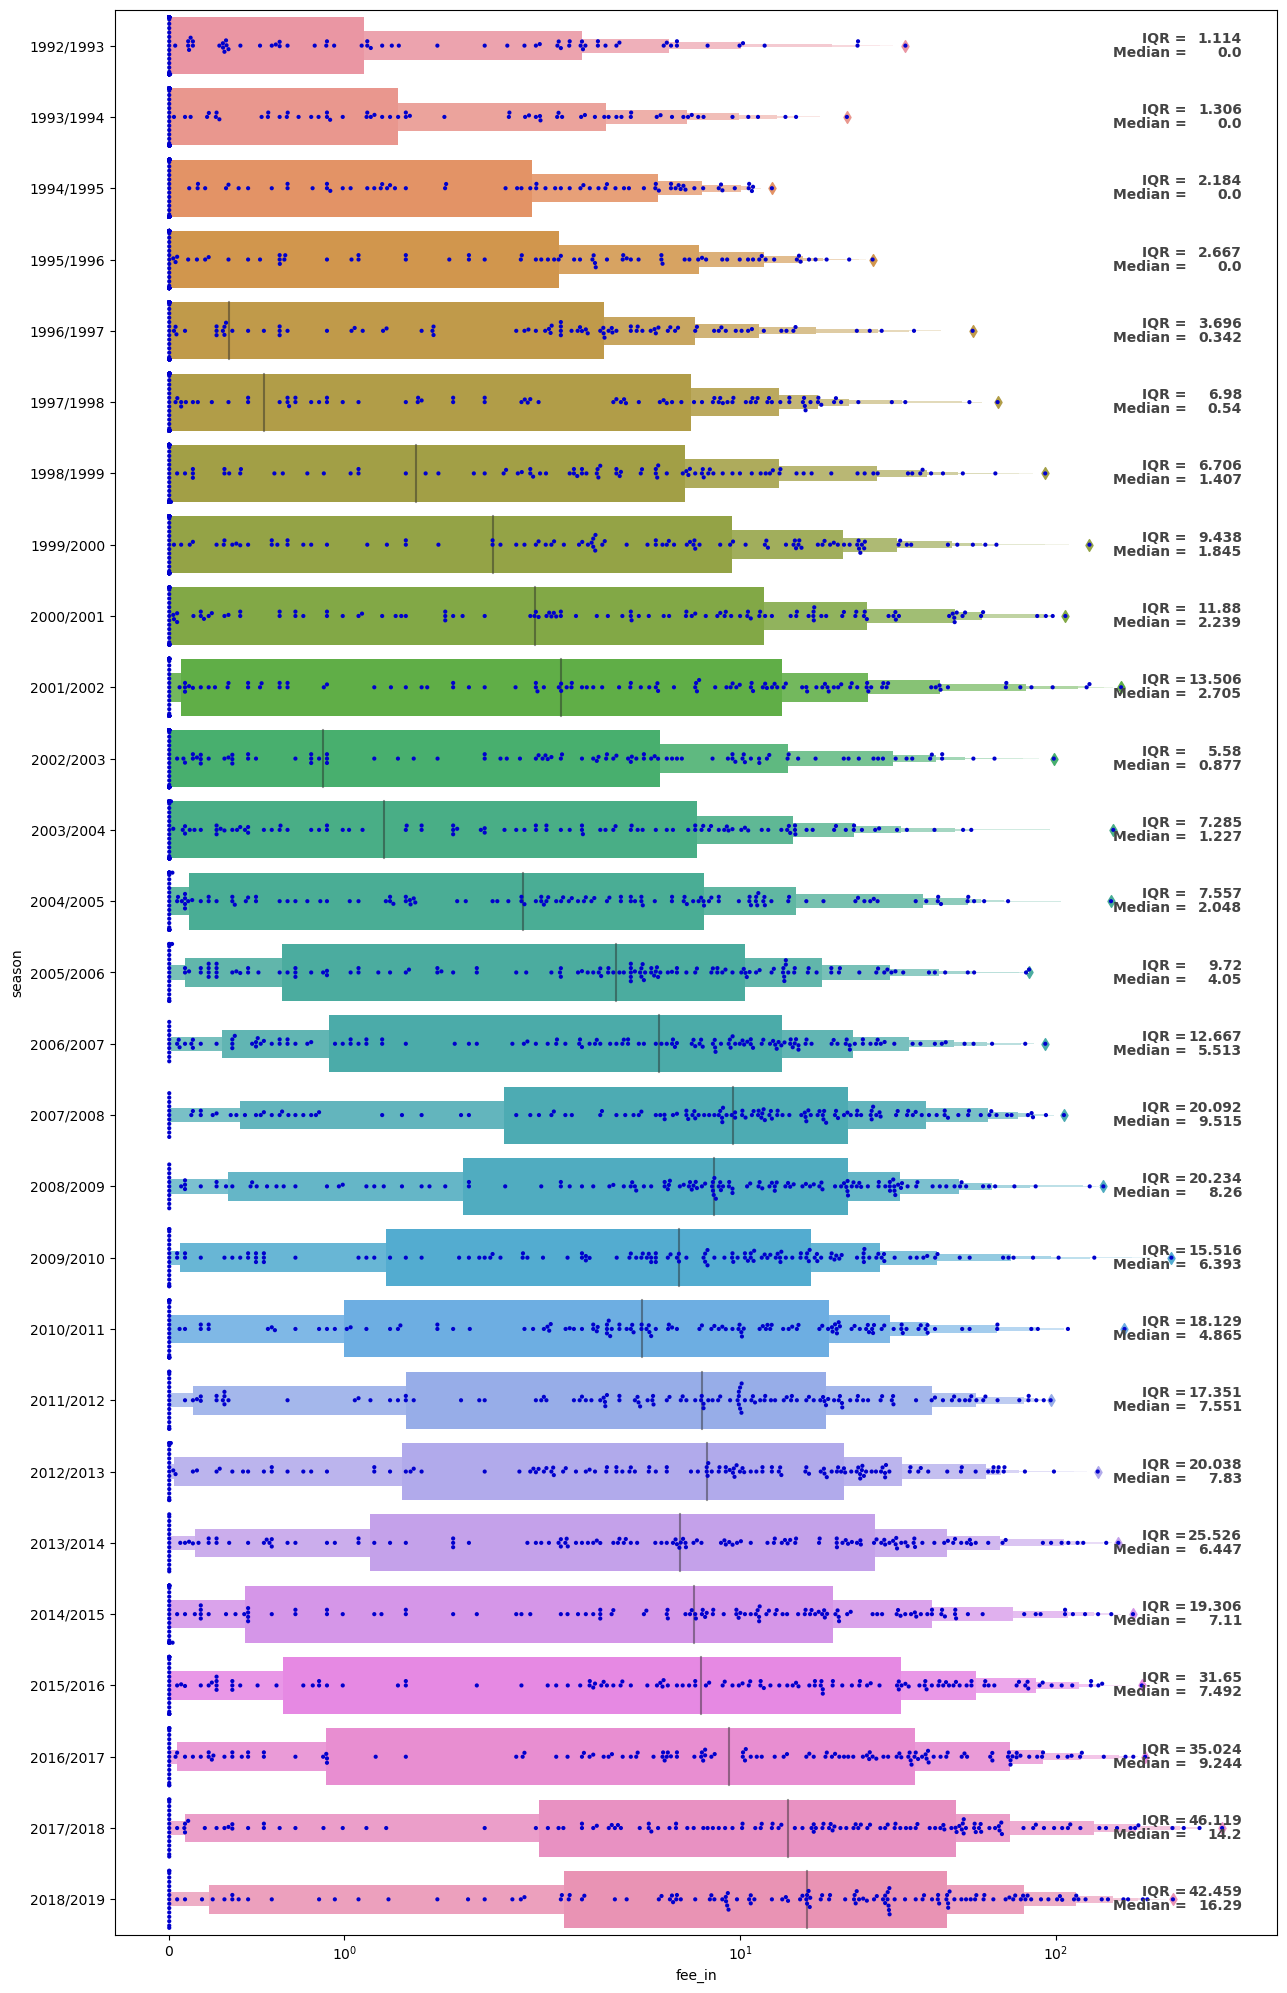

In [140]:
f, ax = plt.subplots(figsize=(15, 25))
ax.set_xscale("symlog")
sns.boxenplot(x="fee_in", y="season",  order = sorted(list(set(clubs_total['season']))), data=clubs_total)
sns.swarmplot(x="fee_in", y="season", order = sorted(list(set(clubs_total['season']))), data=clubs_total,
              size=3, color="mediumblue", linewidth=0)
for i, season in enumerate(sorted(list(set(clubs_total['season'])))):
    IQR = clubs_total[clubs_total["season"]==season]['fee_in'].quantile(q=0.75)-clubs_total[clubs_total["season"]==season]['fee_in'].quantile(q=0.25)
    Median = clubs_total[clubs_total["season"]==season]['fee_in'].median()
    ax.text(260, i,'IQR =', size=10, weight=600, color='#444444', ha='right', va='bottom')
    ax.text(390, i, IQR.round(3), size=10, weight=600, color='#444444', ha='right', va='bottom')
    ax.text(260, i,'Median =', size=10, weight=600, color='#444444', ha='right', va='top')
    ax.text(390, i, round(Median, 3), size=10, weight=600, color='#444444', ha='right', va='top')

В первый же полноценный сезон после введения правила Босмана медианное значение трат оторвалось от нуля и росло до сезона 02/03.  
После этого падения, началась вторая волна роста: рынок стабилизировался к 2008 году, как показывают значения медианы и межквартильного расстояния.   
Лишь в сезоне 2017/2018 максимальное медианное значение изменилось, что можно связать с новым витком роста цен на футболистов: 100+ миллионов фунтов за игрока для суперклубов это новая реальность, а не отталкивающий запрос.  
Ещё одним фактором мне кажется рост отчислений клубам (в первую очередь Английской премьер-лиги) за телеправа и выступление в чемпионате. Сейчас клубы из середины таблицы Англии могут позволить себе тратить на трансферы больше, чем лидеры большинства европейских чемпионатов. Постараюсь найти историю роста выплат клубам и проанализировать этот фактор детальнее в следующих релизах проекта.

### Сезонные графики по лигам

Теперь построю графики трат и доходов в каждой из лиг, начиная с сезона 1992/1993, чтобы понаблюдать за изменениями в лидерах рынка и поискать другие интересные моменты.

#### Траты

In [54]:
ctl_in = clubs_total.groupby(['league_name', 'season'])[['fee_in']].sum().unstack()
ctl_in = ctl_in.append(ctl_in.sum().rename('Total'), sort=False)
ctl_in

fee_in                                                    \
season           1992/1993 1993/1994 1994/1995 1995/1996 1996/1997 1997/1998   
league_name                                                                    
1 Bundesliga        26.483    33.679    49.253    70.691    46.249    57.816   
Eredivisie           4.537     9.195    10.976    13.202     8.618    34.655   
Liga Nos             2.250     0.900     1.580     0.900     4.050     9.766   
Ligue 1             19.114     9.707     1.035     4.365    15.595    40.359   
Premier League      54.759    75.476   121.492   175.160   160.281   224.459   
Premier Liga         0.000     0.122     0.000     0.059     1.013     0.808   
Primera Division     7.347    22.995    37.432    33.453   159.540   165.260   
Serie A            112.458    65.505    29.438    83.590    97.616   176.960   
Total              226.948   217.579   251.206   381.420   492.962   710.083   

                                                          ...            \
season           1998/1999 1999/2000 2000/2001 2001/2002  ... 2009/2010   
league_name                                               ...             
1 Bundesliga        67.136   136.497   104.621   165.543  ...   221.365   
Eredivisie          29.971    44.029    43.310    47.765  ...    48.682   
Liga Nos            12.290     9.455    29.970    35.550  ...    75.539   
Ligue 1             54.828   104.630   189.336   135.628  ...   243.427   
Premier League     339.636   281.704   432.002   515.682  ...   534.429   
Premier Liga         1.440     1.157     5.831    11.135  ...   105.118   
Primera Division   139.588   197.699   346.679   247.273  ...   454.533   
Serie A            281.287   424.405   446.482   683.019  ...   490.333   
Total              926.176  1199.576  1598.231  1841.595  ...  2173.426   

                                                                              \
season           2010/2011 2011/2012 2012/2013 2013/2014 2014/2015 2015/2016   
league_name                                                                    
1 Bundesliga       192.416   200.180   260.202   274.881   331.468   426.735   
Eredivisie          39.385    62.225    44.690    35.763    38.386    52.053   
Liga Nos            83.727   105.438    51.050    92.081   109.733    86.789   
Ligue 1            138.524   222.240   234.375   372.232   156.703   327.324   
Premier League     629.038   576.251   697.591   832.128  1097.517  1316.778   
Premier Liga       196.444   124.943   297.405   290.519    79.611    36.009   
Primera Division   282.820   359.664   147.528   404.725   483.001   551.648   
Serie A            421.624   560.247   509.151   511.462   422.033   649.212   
Total             1983.978  2211.188  2241.992  2813.791  2718.452  3446.548   

                                                
season           2016/2017 2017/2018 2018/2019  
league_name                                     
1 Bundesliga       607.658   651.865   505.003  
Eredivisie          48.719    88.881    83.004  
Liga Nos           111.160    86.482    96.303  
Ligue 1            329.738   709.615   597.005  
Premier League    1493.833  1956.939  1490.555  
Premier Liga       108.931   138.025   114.871  
Primera Division   473.667   801.654   909.838  
Serie A            779.588   922.881  1163.441  
Total             3953.294  5356.342  4960.020  

[9 rows x 27 columns]

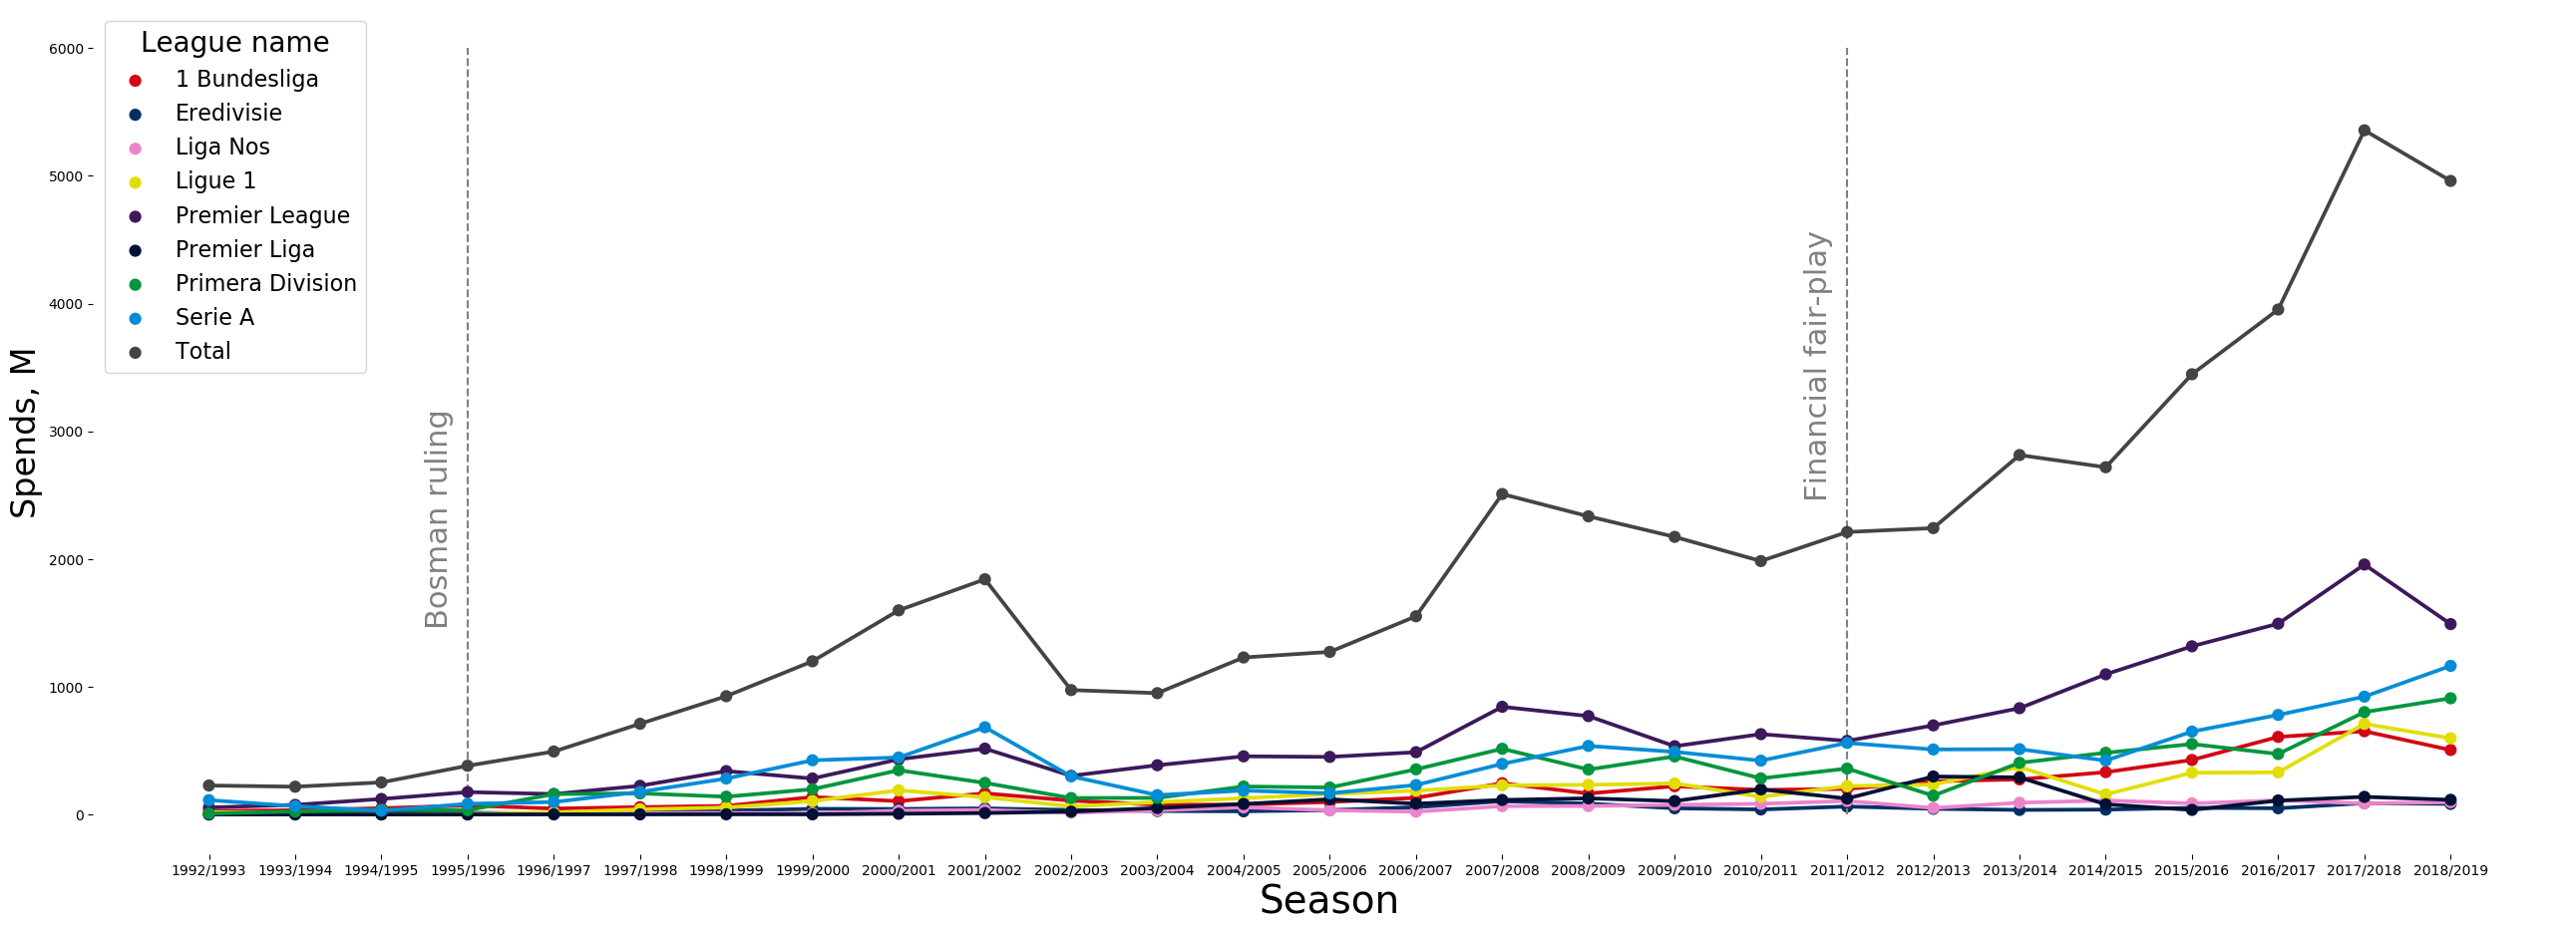

In [55]:
collors = ["#d20614", "#002f63", "#eb84cd", "#e1de07", "#3d195b", "#021035", "#00953e", "#048dd6", "#444444"]
sns.set_palette(sns.color_palette(collors))
fig, ax = plt.subplots(figsize=(32,11))
sns.pointplot(x='season', y='fee_in', hue='league_name', data=ctl_in.stack().reset_index())
plt.xlabel('Season', fontsize = 28)
plt.ylabel('Spends, M', fontsize = 24)
plt.legend(title='League name', title_fontsize = 20, fontsize = 16)
plt.vlines(3, 0, 6000, linestyles='dashed', color='gray')
plt.text(2.5, 1500, 'Bosman ruling', rotation=90, fontsize = 22, color='gray')
plt.vlines(19, 0, 6000, linestyles='dashed', color='gray')
plt.text(18.5, 2500, 'Financial fair-play', rotation=90, fontsize = 22, color='gray')
plt.box(False)

Вижу, что до сезона 2003/2004 Серия А и АПЛ чредовались в качестве лидеров рынка. Но после возникновения финансовых проблем в Лацио и Парме, конкурентов у англичан не осталось. Только в сезонах 09/10 и 11/12 расходы на трансферы были сопоставимы в других лигах.

Ещё один вывод: линейная шкала на оси Y не подходит, чтобы рассмотреть детали, поэтому изменю её на логарифмическую.

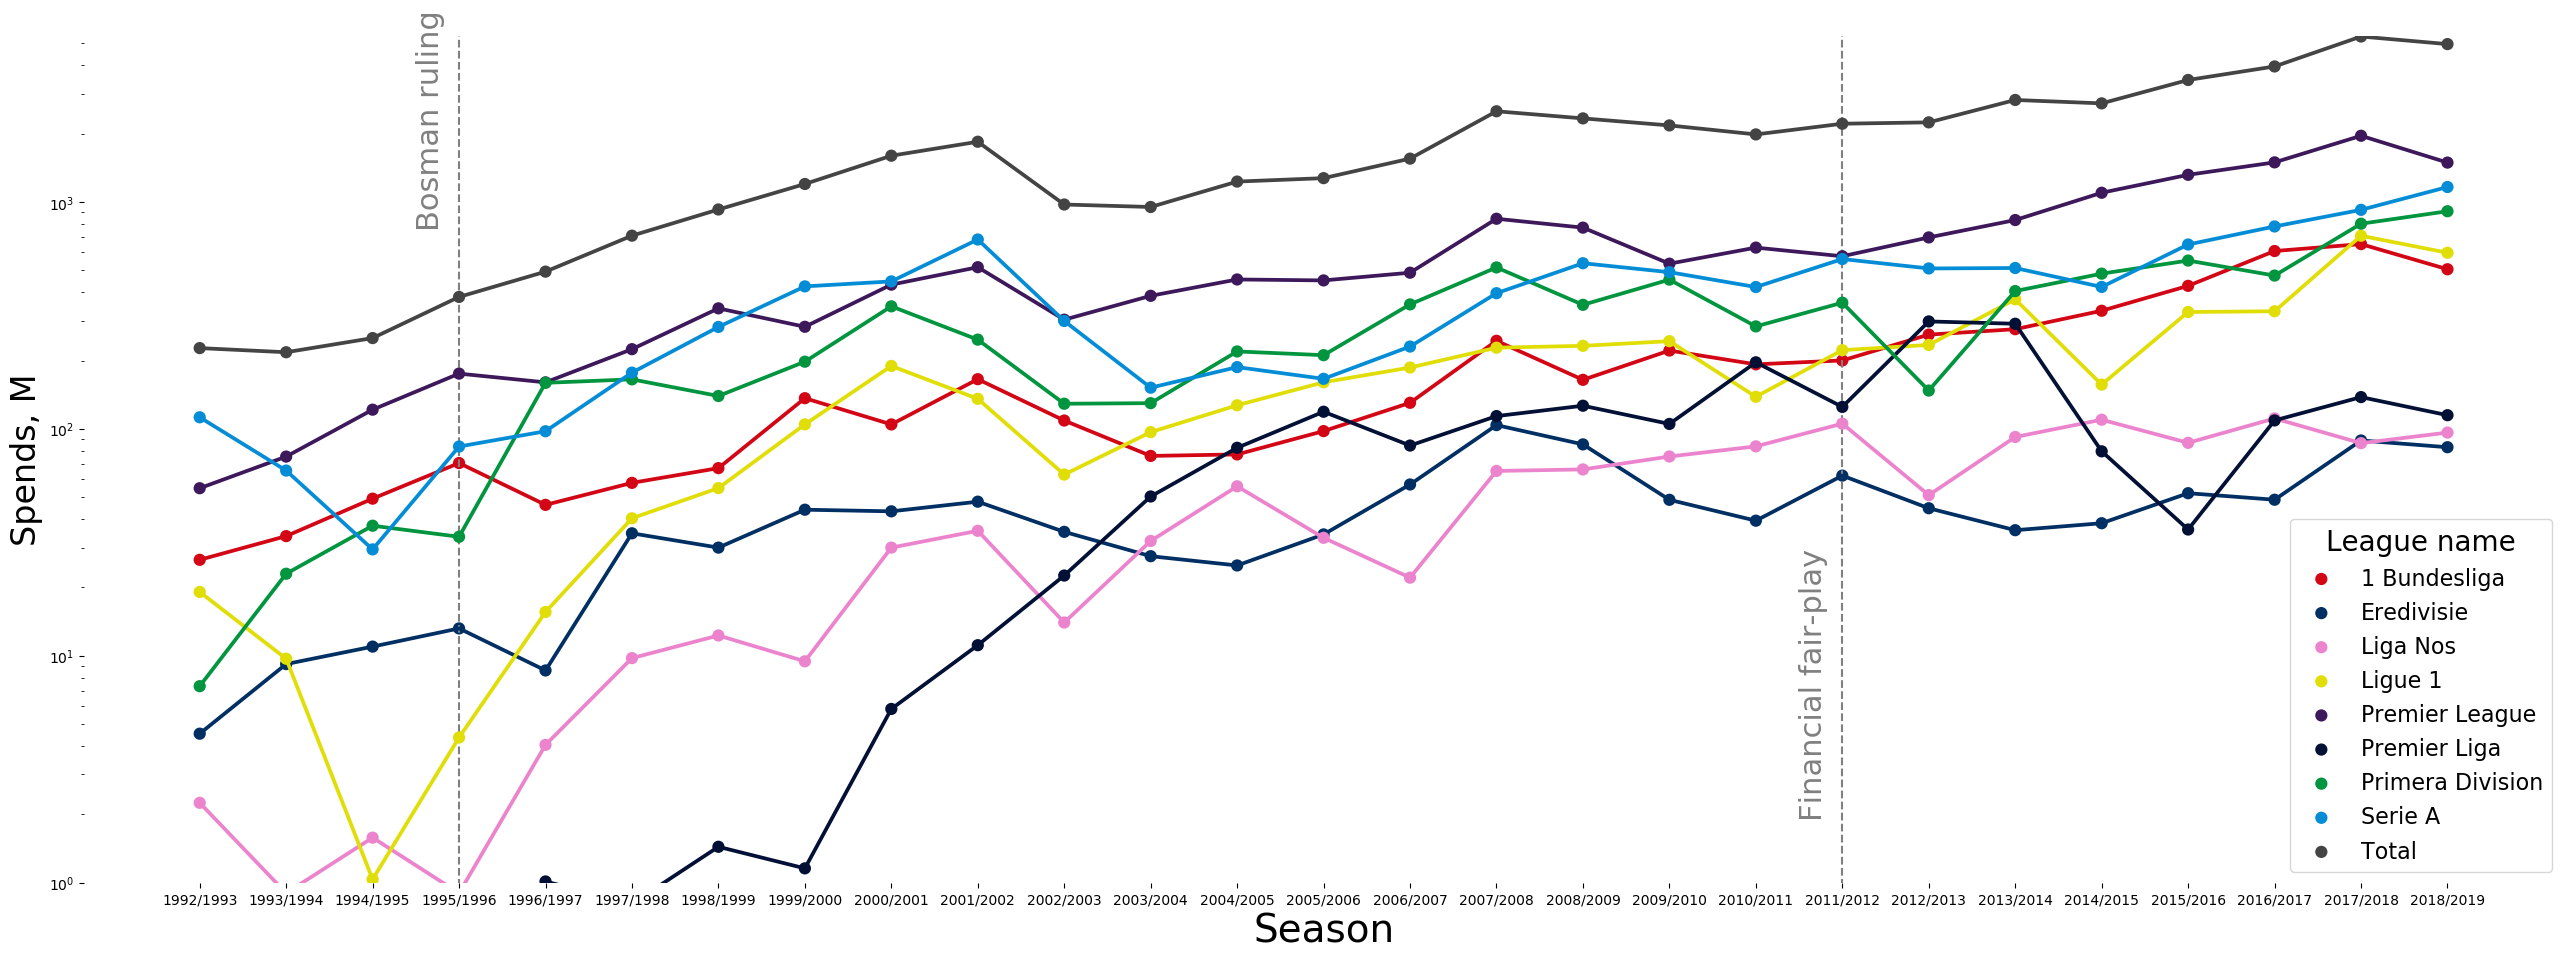

In [56]:
fig, ax = plt.subplots(figsize=(32,11))
y_ = np.arange(0, 2001)
sns.pointplot(x='season', y='fee_in', hue='league_name', data=ctl_in.stack().reset_index())
ax.set_yscale("log")
plt.ylim(1, 5400)
plt.xlabel('Season', fontsize = 28)
plt.ylabel('Spends, M', fontsize = 24)
plt.legend(title='League name', title_fontsize = 20, fontsize = 16)
plt.vlines(3, 0, 6000, linestyles='dashed', color='gray')
plt.text(2.5, 800, 'Bosman ruling', rotation=90, fontsize = 22, color='gray')
plt.vlines(19, 0, 6000, linestyles='dashed', color='gray')
plt.text(18.5, 2, 'Financial fair-play', rotation=90, fontsize = 22, color='gray')
plt.box(False)

Основное внимание на себя обращает график Российской лиги: трансферная активность появилась только на рубеже веков. Но к сезону 03/04 Россия стала расходовать больше Португалии и Нидерландов. А к сезону 10/11 траты были сопоставимы с Бундеслигой и Лигой 1.  
Однако уже в сезоне 13/14 случился спад, вызванный падением курса рубля к основным мировым валютам: только в текущем сезоне(19/20) российские клубы оправились и снова стали тратить значительные средства.

In [57]:
ctl_out = clubs_total.groupby(['league_name', 'season'])[['fee_out']].sum().unstack()
ctl_out = ctl_out.append(ctl_out.sum().rename('Total'), sort=False)
ctl_out

fee_out                                                    \
season           1992/1993 1993/1994 1994/1995 1995/1996 1996/1997 1997/1998   
league_name                                                                    
1 Bundesliga        27.288    22.717    28.843    45.299    34.873    52.231   
Eredivisie           7.203    29.867     7.345    12.690    31.489    33.425   
Liga Nos             2.250     4.050    14.330     4.140    15.345    19.240   
Ligue 1             20.421    14.850     2.615    10.580    45.914    76.896   
Premier League      48.174    50.613    81.405   107.978    97.924   118.774   
Premier Liga         0.360     0.000     0.720     1.800     2.430     1.919   
Primera Division     6.300     3.645    30.447    38.070    47.720    88.750   
Serie A             56.503    28.315    32.730    61.856    87.381   143.761   
Total              168.499   154.057   198.435   282.413   363.076   534.996   

                                                          ...            \
season           1998/1999 1999/2000 2000/2001 2001/2002  ... 2009/2010   
league_name                                               ...             
1 Bundesliga        58.087    51.522    46.969    79.973  ...   120.287   
Eredivisie          71.828    70.559    65.895    63.925  ...    72.729   
Liga Nos            24.528    16.740    53.515    30.513  ...    90.788   
Ligue 1             86.830    72.694   153.254   149.921  ...   189.615   
Premier League     187.369   201.041   301.258   220.572  ...   468.954   
Premier Liga         6.435     8.600     8.235     6.764  ...    76.860   
Primera Division    88.138   194.560   320.499   133.508  ...   221.742   
Serie A            153.657   240.125   210.979   642.143  ...   466.544   
Total              676.872   855.841  1160.604  1327.319  ...  1707.519   

                                                                              \
season           2010/2011 2011/2012 2012/2013 2013/2014 2014/2015 2015/2016   
league_name                                                                    
1 Bundesliga       188.307   171.692   158.756   200.741   186.621   478.823   
Eredivisie          68.396   111.346   103.774   143.554   125.236   141.093   
Liga Nos           155.934   122.302   167.526   169.339   217.960   295.225   
Ligue 1            193.448   165.929   209.759   219.460   209.420   433.455   
Premier League     305.642   387.418   336.420   362.618   606.530   629.405   
Premier Liga        81.154    36.450    75.699   291.114    56.990    78.776   
Primera Division   279.658   282.820   196.960   450.113   517.344   412.448   
Serie A            356.334   491.141   490.501   499.647   395.754   594.185   
Total             1628.873  1769.098  1739.395  2336.586  2315.855  3063.410   

                                                
season           2016/2017 2017/2018 2018/2019  
league_name                                     
1 Bundesliga       493.210   576.986   522.307  
Eredivisie         149.591   212.708    99.015  
Liga Nos           265.963   298.934   299.506  
Ligue 1            351.384   628.615   845.205  
Premier League     785.161  1212.412   488.730  
Premier Liga       159.935    60.800   141.480  
Primera Division   443.220   787.232   776.580  
Serie A            744.510   849.663   869.236  
Total             3392.974  4627.350  4042.059  

[9 rows x 27 columns]

#### Доходы

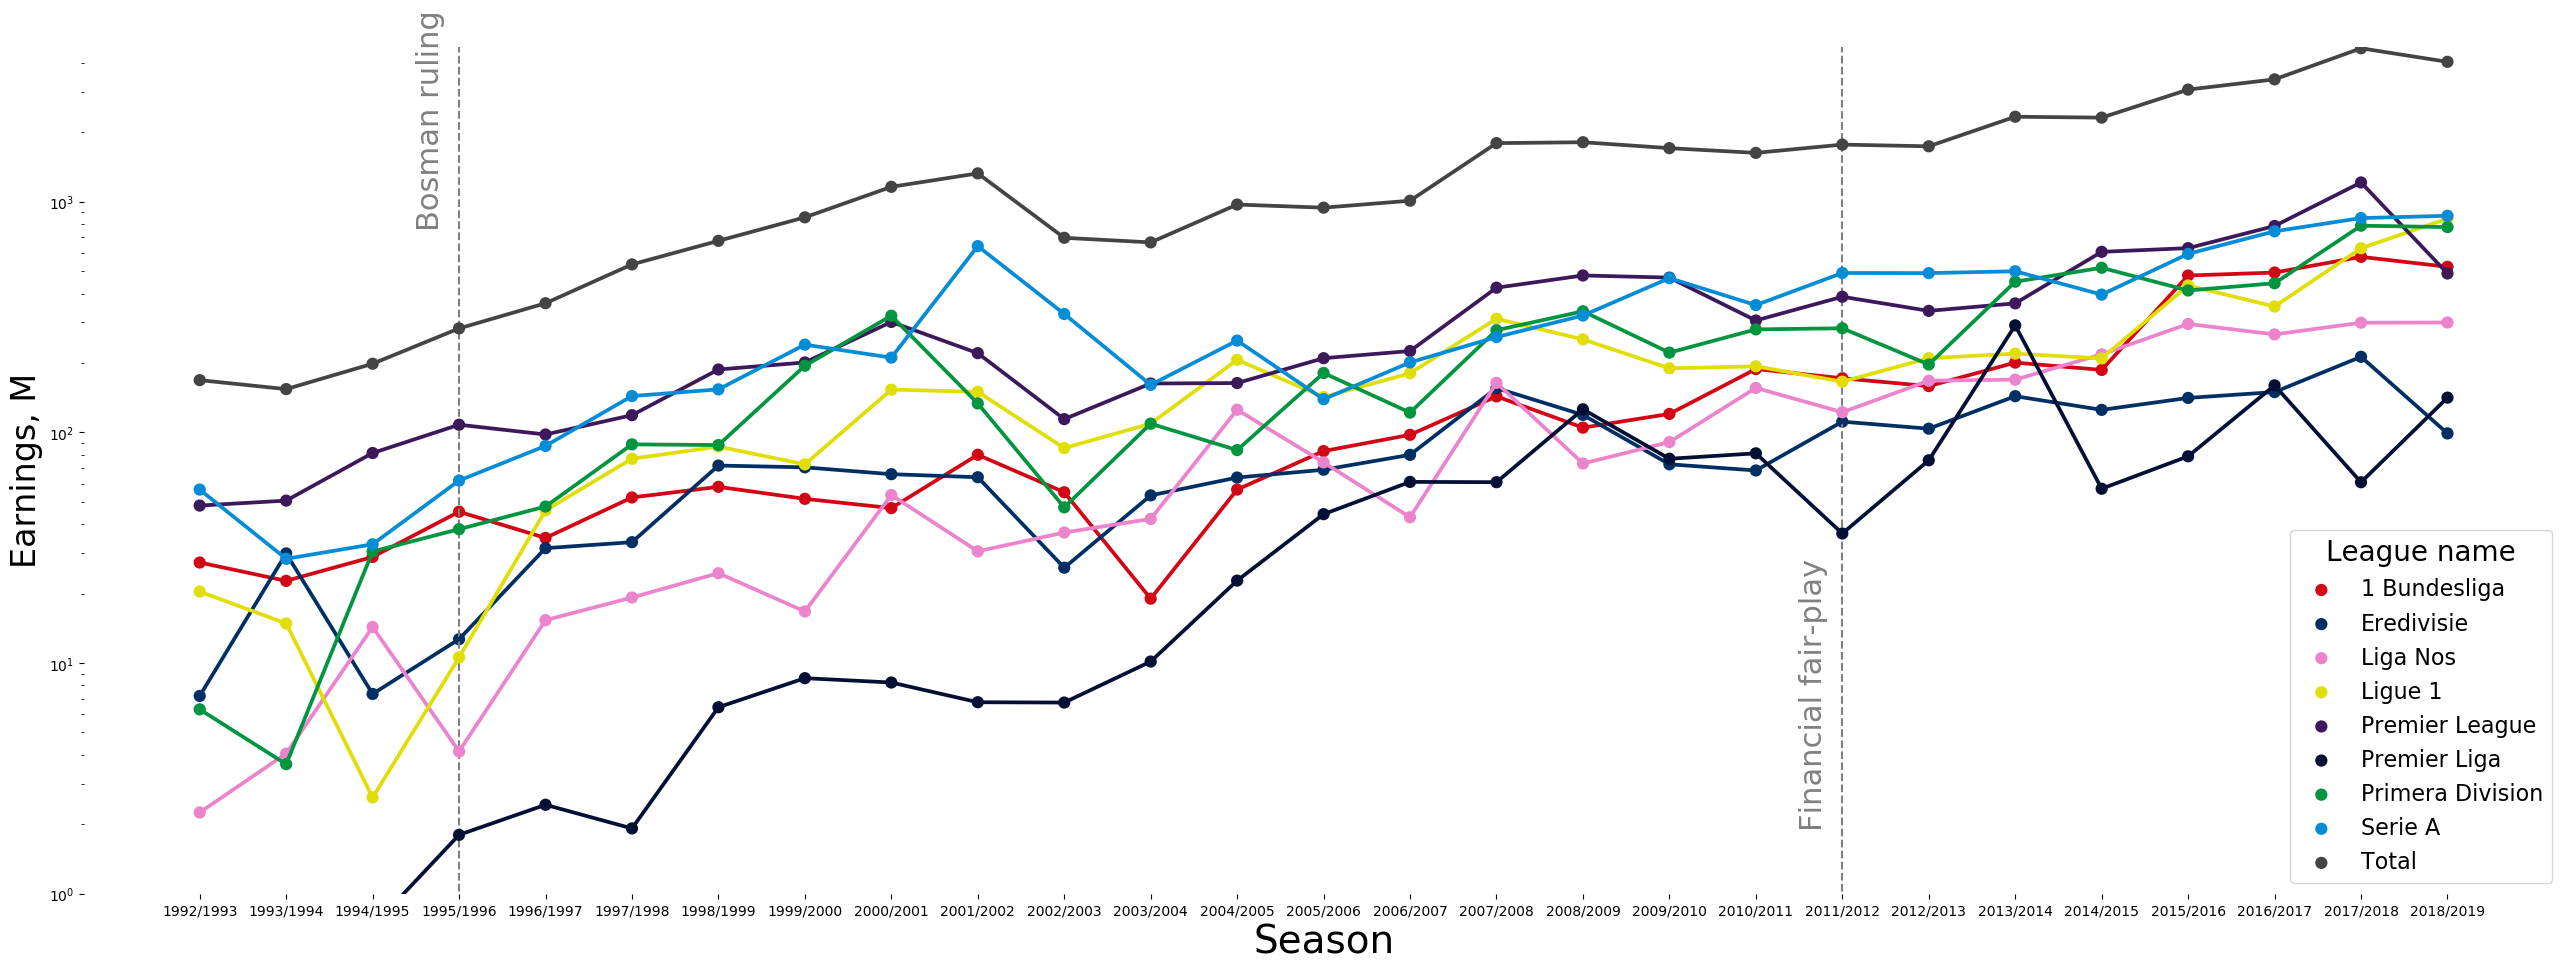

In [58]:
fig, ax = plt.subplots(figsize=(32,11))
sns.pointplot(x='season', y='fee_out', hue='league_name', data=ctl_out.stack().reset_index())
ax.set_yscale("log")
plt.ylim(1, 4700)
plt.xlabel('Season', fontsize = 28)
plt.ylabel('Earnings, M', fontsize = 24)
plt.legend(title='League name', title_fontsize = 20, fontsize = 16)
plt.vlines(3, 0, 6000, linestyles='dashed', color='gray')
plt.text(2.5, 800, 'Bosman ruling', rotation=90, fontsize = 22, color='gray')
plt.vlines(19, 0, 6000, linestyles='dashed', color='gray')
plt.text(18.5, 2, 'Financial fair-play', rotation=90, fontsize = 22, color='gray')
plt.box(False)

На графике продаж отсутствует лидер-гегемон. Основные действующие лица те же: АПЛ и Серия А, но конкуренция значительно ожесточённее.  

Неожиданный инсайт: сезон 01/02 был самым успешным с точки зрения выручки для одной лиги вплоть до сезона 16/17. Отличилась Серия А: это был год распродаж, связанный с рисками банкротства сразу нескольких клубов.

Португальская лига навязывала реальную борьбу Бундеслиге и Лиге 1 на промежутке 10/11-14/15. Однако после этого видим значительный рост доходов с продаж в Германии и Франции и примерно тот же уровень в Лиге Нос. Думаю, в первую очередь это связано с повышением среднего уровня клубов Бундеслиги и Лиги 1, в то время как в Португалии значителен разрыв в классе между Порто, Бенфикой, Спортингом, Брагой и остальными клубами.  

Российские клубы зарабатывают на трансферах значительно меньше, чем в других топ-лигах: средний уровень доходов сопоставим разве что с Эредивизие. Только в сезонах 08/09 и 13/14 происходили всплески — за счёт единичных крупных продаж.

## Выводы и дальнейшие планы

Даже поверхностный анализ строчек с суммами переходов игроков из одного футбольного клуба в другой рассказывает множество интересных историй: воспитание и продажа талантов как футбольная национальная идея Португалии, итальянские ["рождение и смерть феодальной утопии в футболе"](https://castbox.fm/vb/169534606), нездоровый баланс трат и доходов в России... И это только вершина айсберга!

В дальнейшем я **планирую**:
* Провести аналогичный анализ отдельно для лиг
* Найти данные о позициях клубов в турнирных таблицах и проанализировать зависимость с суммами расходов на трансферы
* Найти данные о выплатах за телеправа и итоговое место в таблице, чтобы проверить гипотезу о росте расходов на трансферы в соответствии с ростом выплат клубам по этим статьям
* Построить модель, описывающую рост трат на трансферы
* Найти клубы, которые специализируются на покупке молодых игроков с целью дальнейшей продажи. Проанализировать их успехи
* Проанализировать, как различается поведение клубов на рынке в летнее и зимнее трансферные окна
* Проанализировать эффективность массовых закупок клубами  
...

Если у вас есть интересные идеи, пишите мне в __Telegram__: @EugeneKartashov